In [105]:
import pandas as pd
import numpy as np
import math

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [106]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

In [107]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

# Variable

In [108]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [109]:
def r2(actual: np.ndarray, predicted: np.ndarray):
    """ R2 Score """
    return r2_score(actual, predicted)

def adjr2(actual: np.ndarray, predicted: np.ndarray, rowcount: int, featurecount: int):
    """ R2 Score """
    return 1-(1-r2(actual,predicted))*(rowcount-1)/(rowcount-featurecount)

def mse(actual, predicted):
    return mean_squared_error(actual, predicted)

def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

def model_results(actual, predicted, rowcount, featurecount):
    print('r-squared: ', round(r2(actual, predicted),4))
    print('adj r-squared', round(adjr2(actual,predicted,rowcount, featurecount),4))
    print('mse: ', round(mse(actual, predicted),4))
    print('rmse: ', round(rmse(actual, predicted),4))
    print('rmse: ', eval_measures.rmse(actual,predicted,axis=0))

In [110]:
def load_taylor():
    
    gdpc1_df = pd.read_csv('./data/GDPC1.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdpc1_df:', gdpc1_df.shape)
    gdppot_df = pd.read_csv('./data/GDPPOT.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdppot_df:', gdppot_df.shape)
    gdpdef_df = pd.read_csv('./data/GDPDEF.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdpdef_df:', gdpdef_df.shape)
    fed_df = pd.read_csv('./data/FEDFUNDS.csv', parse_dates=['observation_date'], skiprows=10)
    print('fed_df:', fed_df.shape)
    
    
    taylor_df = gdpc1_df.merge(gdppot_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                        .merge(gdpdef_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                        .merge(fed_df, how='outer', left_on='observation_date', right_on='observation_date')

    taylor_df.dropna(inplace=True)
    taylor_df
    
    
    #taylor_df = pd.DataFrame()
    taylor_df['ffef_tr'] = taylor_df['GDPDEF_PC1'] + 2    \
                            +0.5*(taylor_df['GDPDEF_PC1'] - 2)    \
                            +0.5*(taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100

    taylor_df['gap_inf'] = 0.5*(taylor_df['GDPDEF_PC1'] - 2) 
    taylor_df['gap_gdp'] = 0.5*(taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100

    taylor_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    taylor_df = taylor_df.set_index('DATE')
    
    return taylor_df



def load_misery():
    
    t_df = pdr.DataReader(['FEDFUNDS','CPIAUCSL', 'UNRATE'], data_source, start_date)
    t_df.dropna(inplace=True)
    print('t_df:', t_df.shape)

    #u_df = pd.read_csv('./data/CPIAUCSL.csv', parse_dates=['observation_date'], skiprows=10)
    #u_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    #u_df.set_index('DATE', inplace=True)
    u_df = pd.read_csv('./data/CPIAUCSL_PC1.csv', parse_dates=['DATE'])
    #u_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    u_df.set_index('DATE', inplace=True)
    print('u_df:', u_df.shape)

    misery_df = pd.merge(t_df,u_df, left_index=True, right_index=True )
    #misery_df['m_index'] = abs(misery_df['CPIAUCSL_CH1']) + misery_df['UNRATE']
    #misery_df['m_index'] = (misery_df['CPIAUCSL_CH1']) + misery_df['UNRATE']
    misery_df['m_index'] = (misery_df['CPIAUCSL_PC1']) + misery_df['UNRATE']
    print('misery_df:', misery_df.shape)  
    
    return misery_df



def time_split(df):
    t_df = df.copy()

    # Split Data
    splt_index = round(t_df.shape[0] * 0.8)
    train_df = t_df[:splt_index]
    print('train_df: ' , train_df.shape)

    end_index = splt_index - t_df.shape[0]
    test_df = t_df[end_index:]
    print('test_df: ' , test_df.shape)
    
    return train_df, test_df

# Dataset FRED Data

In [111]:
taylor_df = load_taylor()
taylor_df

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,ffef_tr,gap_inf,gap_gdp
DATE,,,,,,,
1954-07-01,2880.482,2727.099666,0.7,0.80,4.862188,-0.65,2.812188
1954-10-01,2936.852,2743.726730,0.8,0.85,5.719397,-0.60,3.519397
1955-01-01,3020.746,2760.136280,1.0,1.39,7.220957,-0.50,4.720957
1955-04-01,3069.910,2777.950765,1.3,1.43,8.204939,-0.35,5.254939
1955-07-01,3111.379,2795.471543,1.9,1.68,9.500343,-0.05,5.650343
...,...,...,...,...,...,...,...
2022-04-01,21708.160,20153.810000,7.7,0.33,16.406219,2.85,3.856219
2022-07-01,21851.134,20245.660000,7.3,1.68,15.914983,2.65,3.964983
2022-10-01,21989.981,20334.210000,6.4,3.08,14.671392,2.20,4.071392


In [112]:
misery_df = load_misery()
misery_df

t_df: (831, 3)
u_df: (909, 1)
misery_df: (831, 5)


,FEDFUNDS,CPIAUCSL,UNRATE,CPIAUCSL_PC1,m_index
DATE,,,,,
1954-07-01,0.80,26.860,5.8,0.26129,6.06129
1954-08-01,1.22,26.850,6.0,0.00000,6.00000
1954-09-01,1.07,26.810,6.1,-0.29751,5.80249
1954-10-01,0.85,26.720,5.7,-0.85343,4.84657
1954-11-01,0.83,26.780,5.3,-0.26071,5.03929
...,...,...,...,...,...
2023-05-01,5.06,303.294,3.7,4.12884,7.82884
2023-06-01,5.08,303.841,3.6,3.09200,6.69200
2023-07-01,5.12,304.348,3.5,3.29908,6.79908


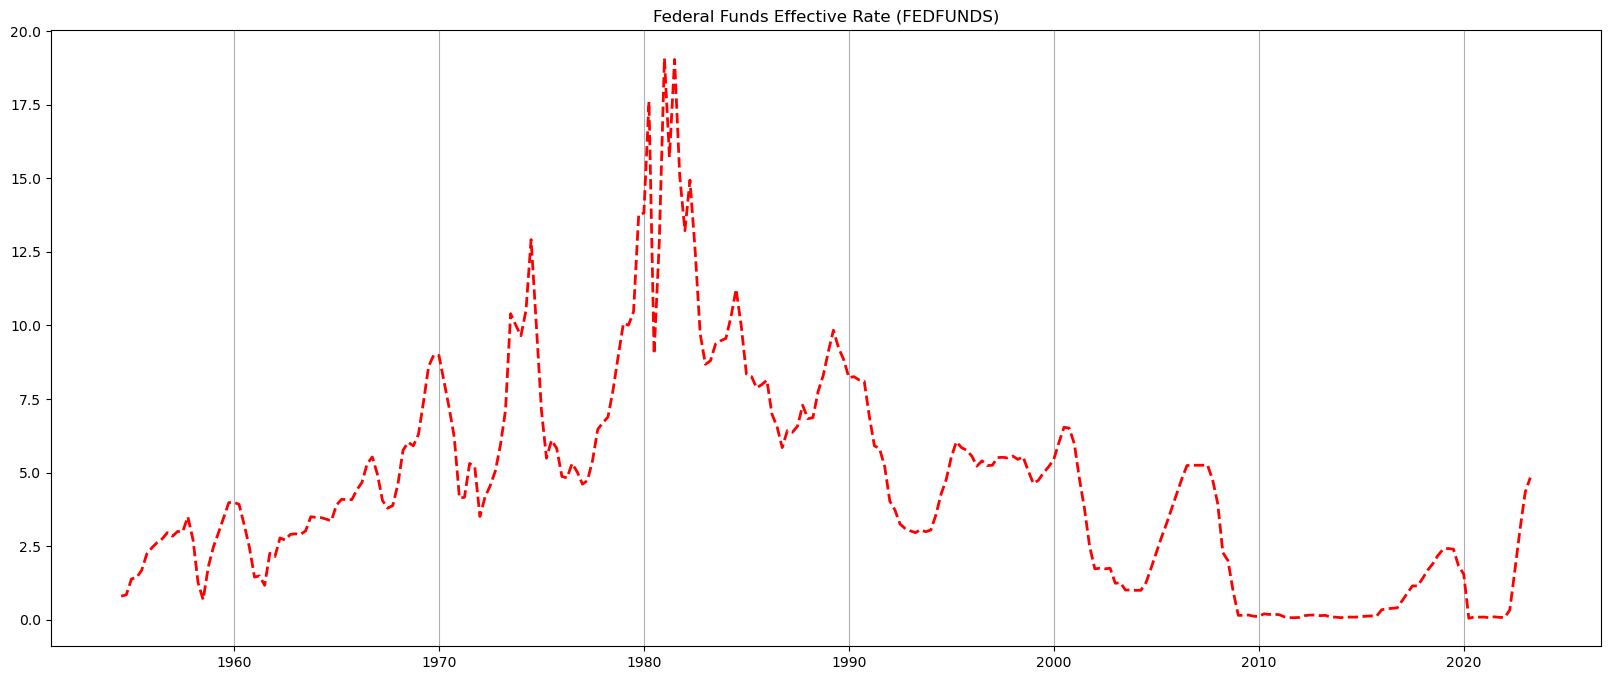

In [113]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Federal Funds Effective Rate (FEDFUNDS)');

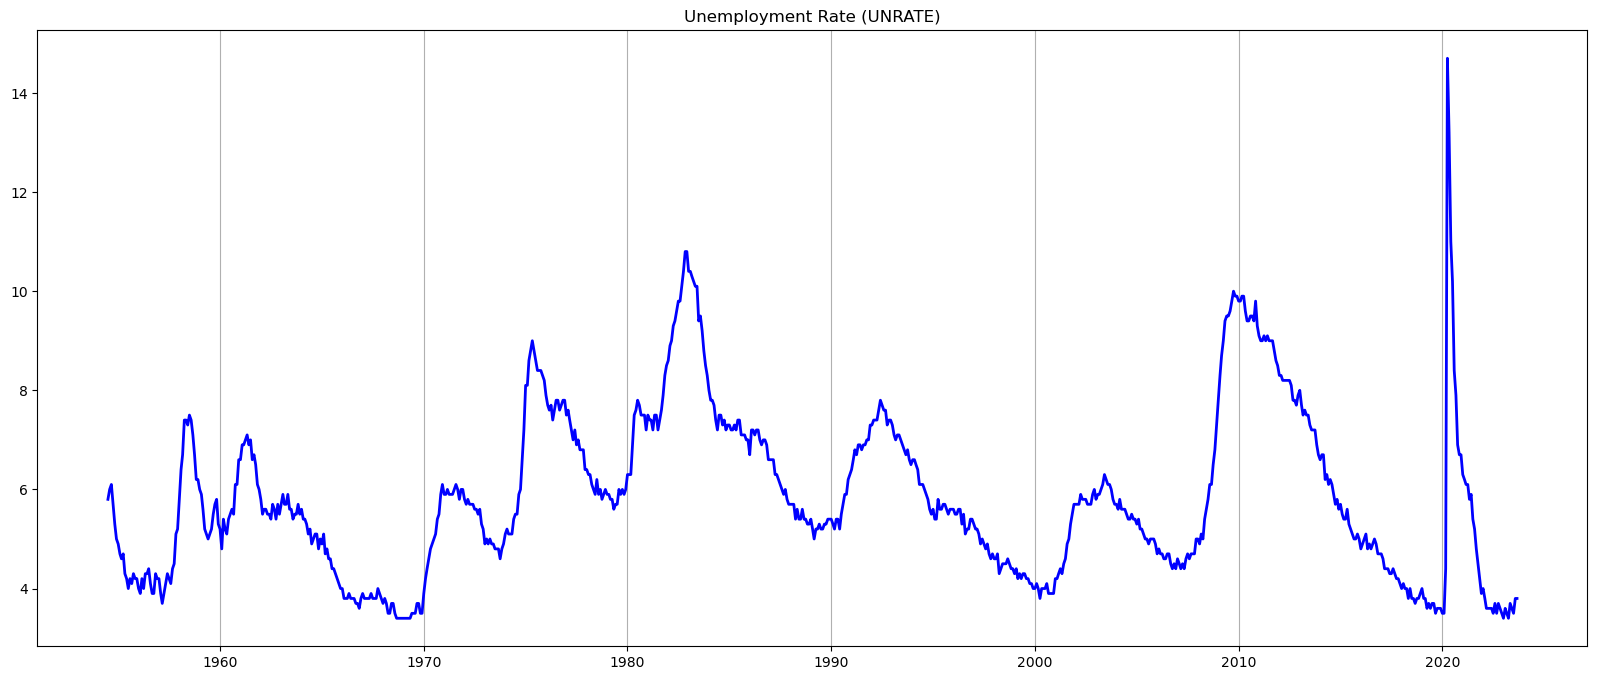

In [114]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(misery_df.index, misery_df['UNRATE'], color='blue',linewidth=2)

ax.set(title='Unemployment Rate (UNRATE)');

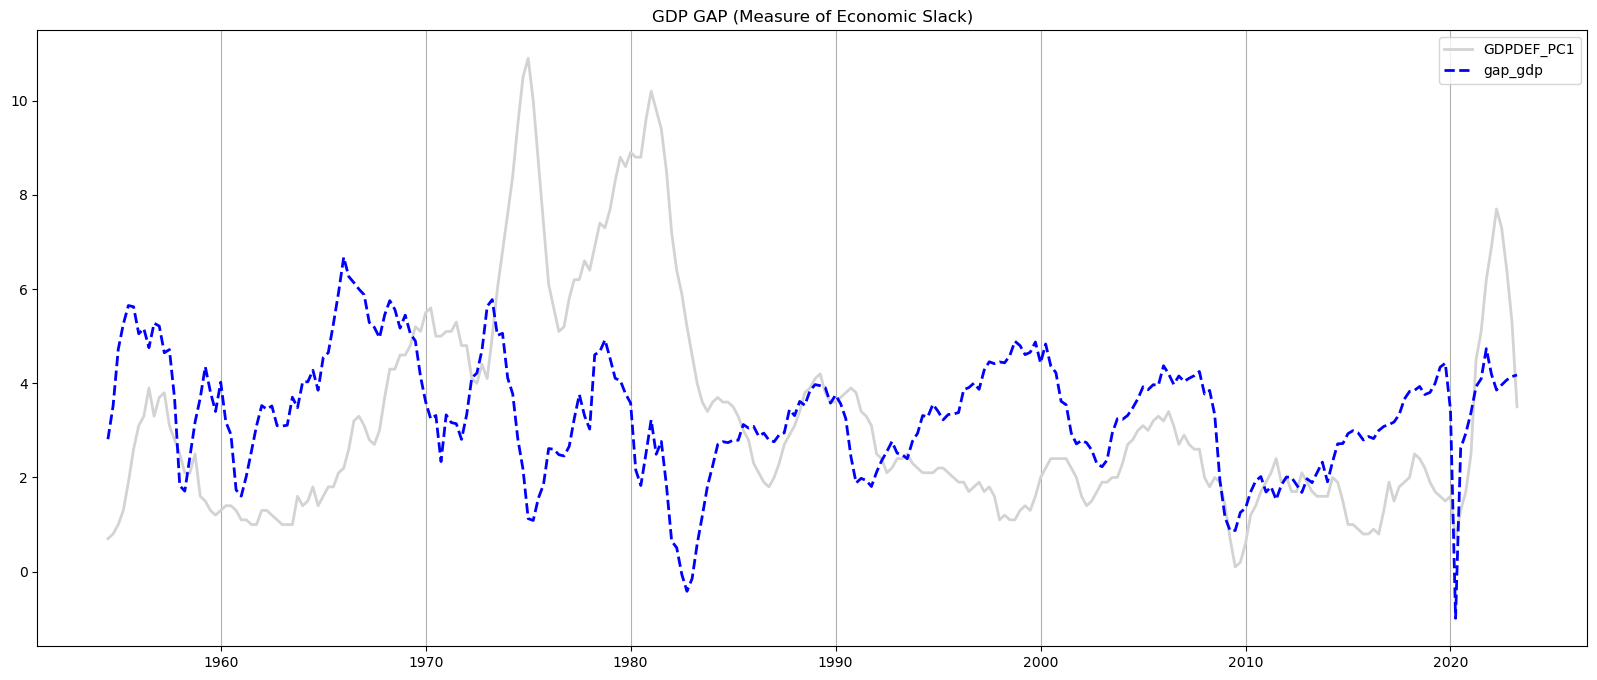

In [115]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['GDPDEF_PC1'], 'lightgray', linewidth=2)
#ax.plot(taylor_df.index, taylor_df['GDPPOT'], 'lightgray', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_gdp'], color='blue', linestyle='--', linewidth=2)

#ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(misery_df.index, misery_df['m_index'], 'orange', linestyle='--', linewidth=1)

ax.legend(["GDPDEF_PC1","gap_gdp"])
ax.set(title='GDP GAP (Measure of Economic Slack)');

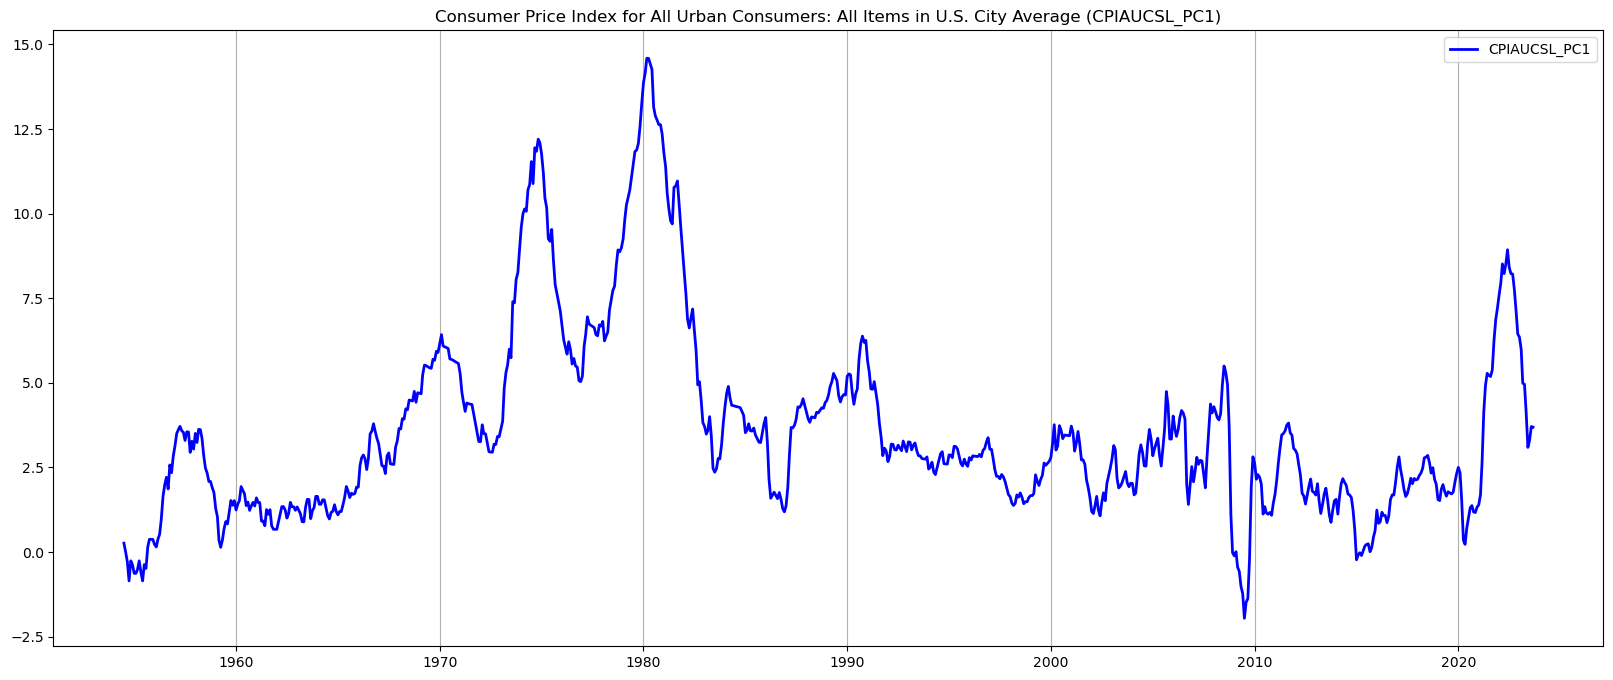

In [116]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(misery_df.index, misery_df['CPIAUCSL_PC1'], 'blue', linewidth=2)

ax.legend(["CPIAUCSL_PC1"])
ax.set(title='Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL_PC1)');

# Taylor Rule
The FRED® Blog
https://fredblog.stlouisfed.org/2014/04/the-taylor-rule/

This graph shows in blue the Taylor Rule, which is a simple formula that John Taylor devised to guide policymakers. It calculates what the federal funds rate should be, as a function of the output gap and current inflation. Here, we measure the output gap as the difference between potential output (published by the Congressional Budget Office) and real GDP. Inflation is measured by changes in the CPI, and we use a target inflation rate of 2%. We also assume a steady-state real interest rate of 2%. These are a lot of assumptions, and you are welcome to change them on the graph by playing around with the formula to see how the Taylor Rule matches up with the effective federal funds rate. To read up on the Taylor Rule, see the original article or an article by former St. Louis Fed president William Poole.

How this graph was created: To create a new series from several series, first add the series by modifying the existing series in the “Graph” tab. Once you have assembled them all, expand the series section in the same tab and “create your own transformation.” Finally, as the axis legend has become unwieldy, remove it by checking off the mark in the graph tab.

Suggested by: Christian Zimmermann

Update: A previous version did not multiply the output gap by 100.

View on FRED, series used in this post: FEDFUNDS, GDPC1, GDPDEF, GDPPOT

# Fred Calculations

In [117]:
base_df = pd.read_csv('./data/fred.csv', parse_dates=['fund_date','taylor_date'])
base1_df = base_df[['fund_date','FEDFUNDS']].dropna().copy()
base1_df.sort_values(by='fund_date', inplace = True)
base2_df = base_df[['taylor_date','GDPPOT_GDPC1_GDPDEF_PC1']].copy()
base2_df.sort_values(by='taylor_date', inplace = True)
base2_df.dropna(inplace=True)

In [118]:
base1_df

,fund_date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
826,2023-05-01,5.06
827,2023-06-01,5.08
828,2023-07-01,5.12
829,2023-08-01,5.33


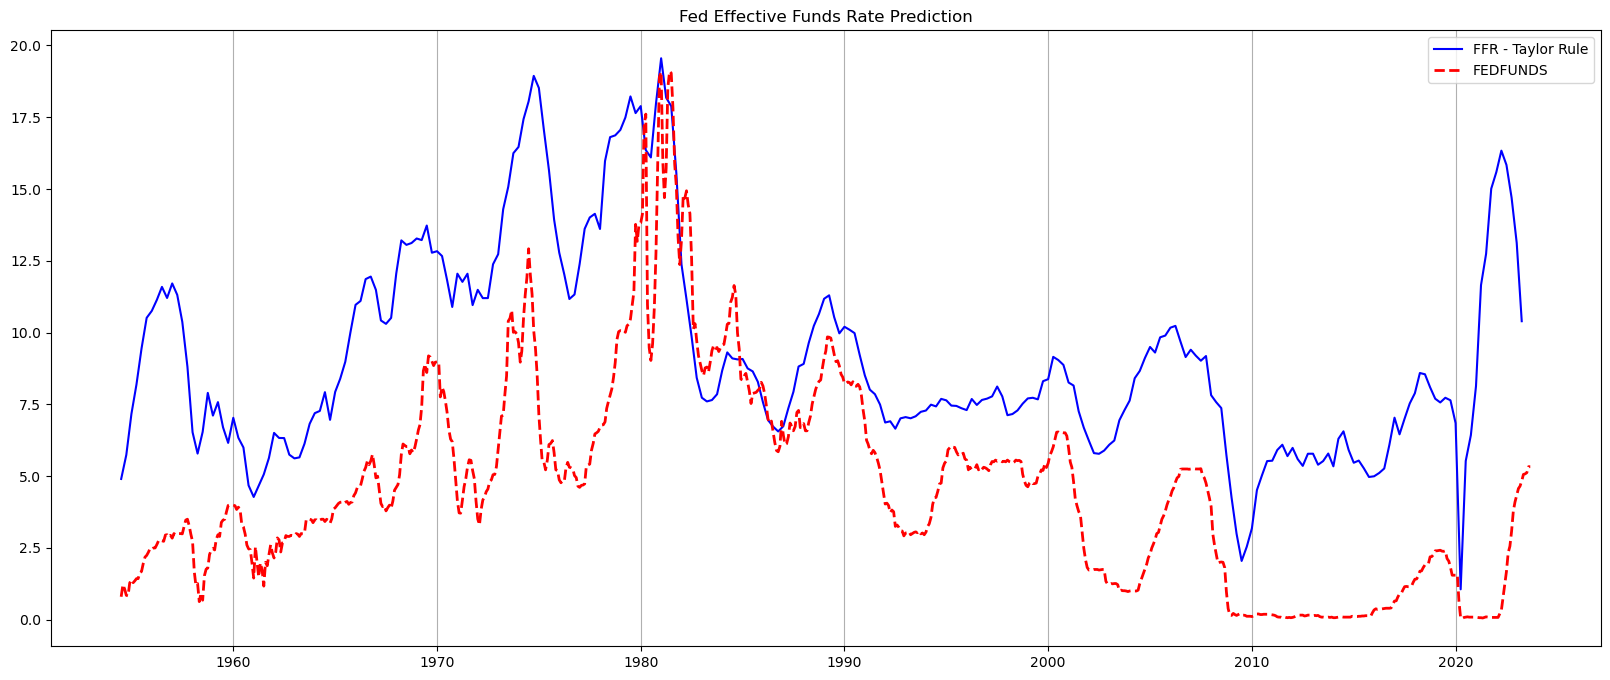

In [119]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(base2_df['taylor_date'], base2_df['GDPPOT_GDPC1_GDPDEF_PC1'], 'blue')
ax.plot(base1_df['fund_date'], base1_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.legend(["FFR - Taylor Rule","FEDFUNDS"])

ax.set(title='Fed Effective Funds Rate Prediction');

## Calculation 1

In [120]:
taylor_df = load_taylor()
taylor_df.head()

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,ffef_tr,gap_inf,gap_gdp
DATE,,,,,,,
1954-07-01,2880.482,2727.099666,0.7,0.80,4.862188,-0.65,2.812188
1954-10-01,2936.852,2743.726730,0.8,0.85,5.719397,-0.60,3.519397
1955-01-01,3020.746,2760.136280,1.0,1.39,7.220957,-0.50,4.720957
1955-04-01,3069.910,2777.950765,1.3,1.43,8.204939,-0.35,5.254939
1955-07-01,3111.379,2795.471543,1.9,1.68,9.500343,-0.05,5.650343


In [121]:
model_results(taylor_df['FEDFUNDS'], taylor_df['ffef_tr'], taylor_df.shape[0], 2 )

r-squared:  -1.2856
adj r-squared -1.2939
mse:  30.4347
rmse:  5.5168
rmse:  5.516763713751516


long_df: (1104, 3)


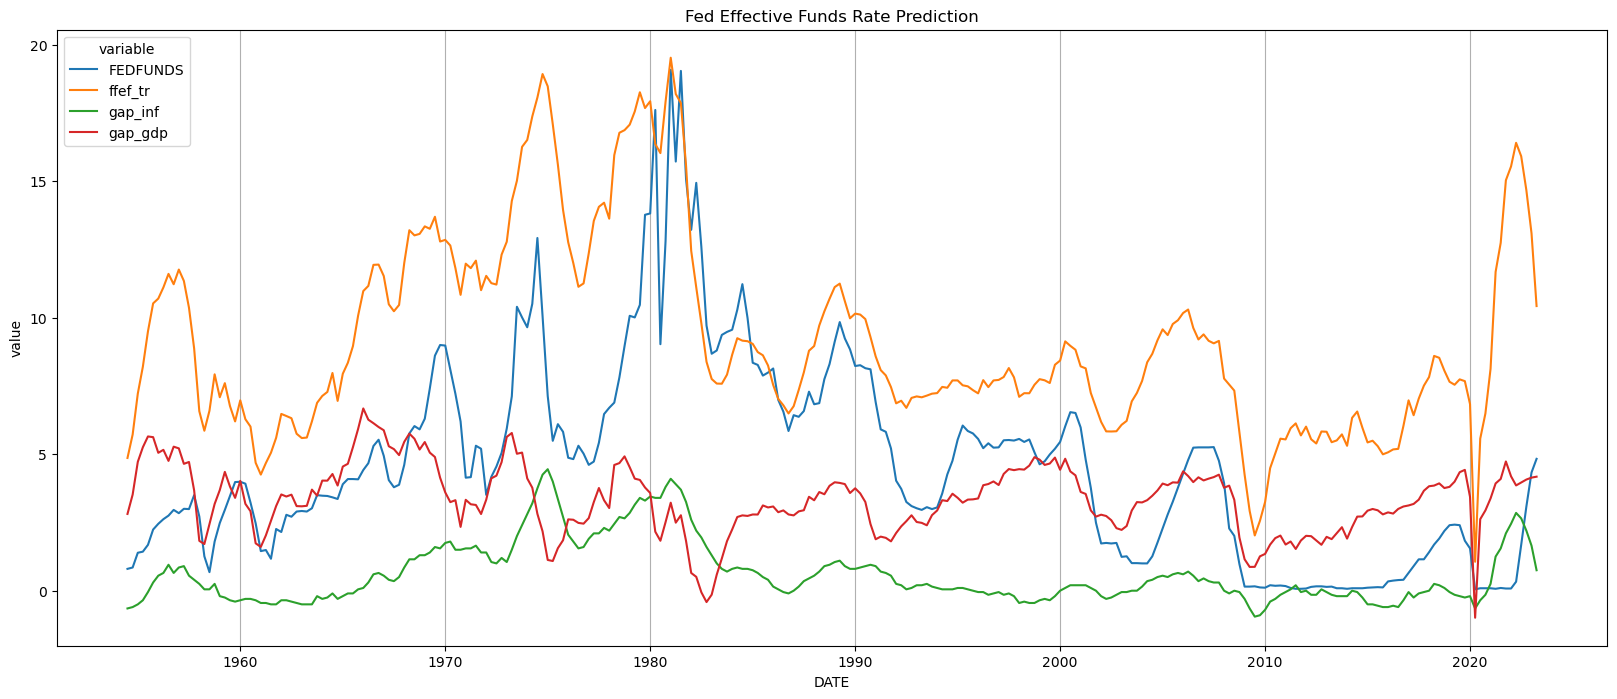

In [122]:
# Long 
long_df = taylor_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['DATE','FEDFUNDS','ffef_tr','gap_inf','gap_gdp']].melt(id_vars=['DATE'])
print('long_df:', long_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
#ax.plot(long_df['observation_date'], long_df['value'], color='variable')
sns.lineplot(x = 'DATE', y = 'value', data=long_df, hue='variable')

ax.set(title='Fed Effective Funds Rate Prediction');

long_df: (1104, 3)


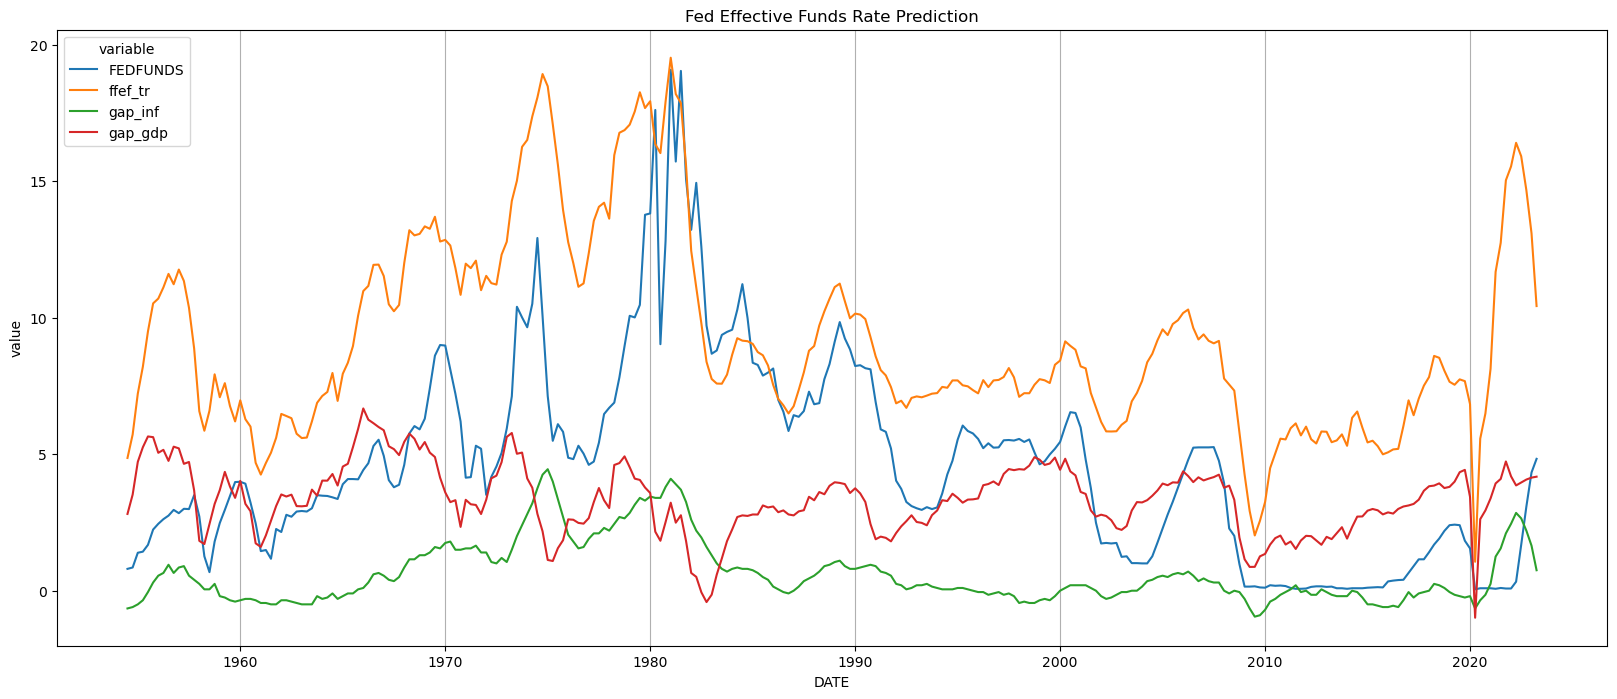

In [123]:
# Long 
long_df = taylor_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['DATE','FEDFUNDS','ffef_tr','gap_inf','gap_gdp']].melt(id_vars=['DATE'])
print('long_df:', long_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
#ax.plot(long_df['observation_date'], long_df['value'], color='variable')
sns.lineplot(x = 'DATE', y = 'value', data=long_df, hue='variable')

ax.set(title='Fed Effective Funds Rate Prediction');

long_df: (828, 3)


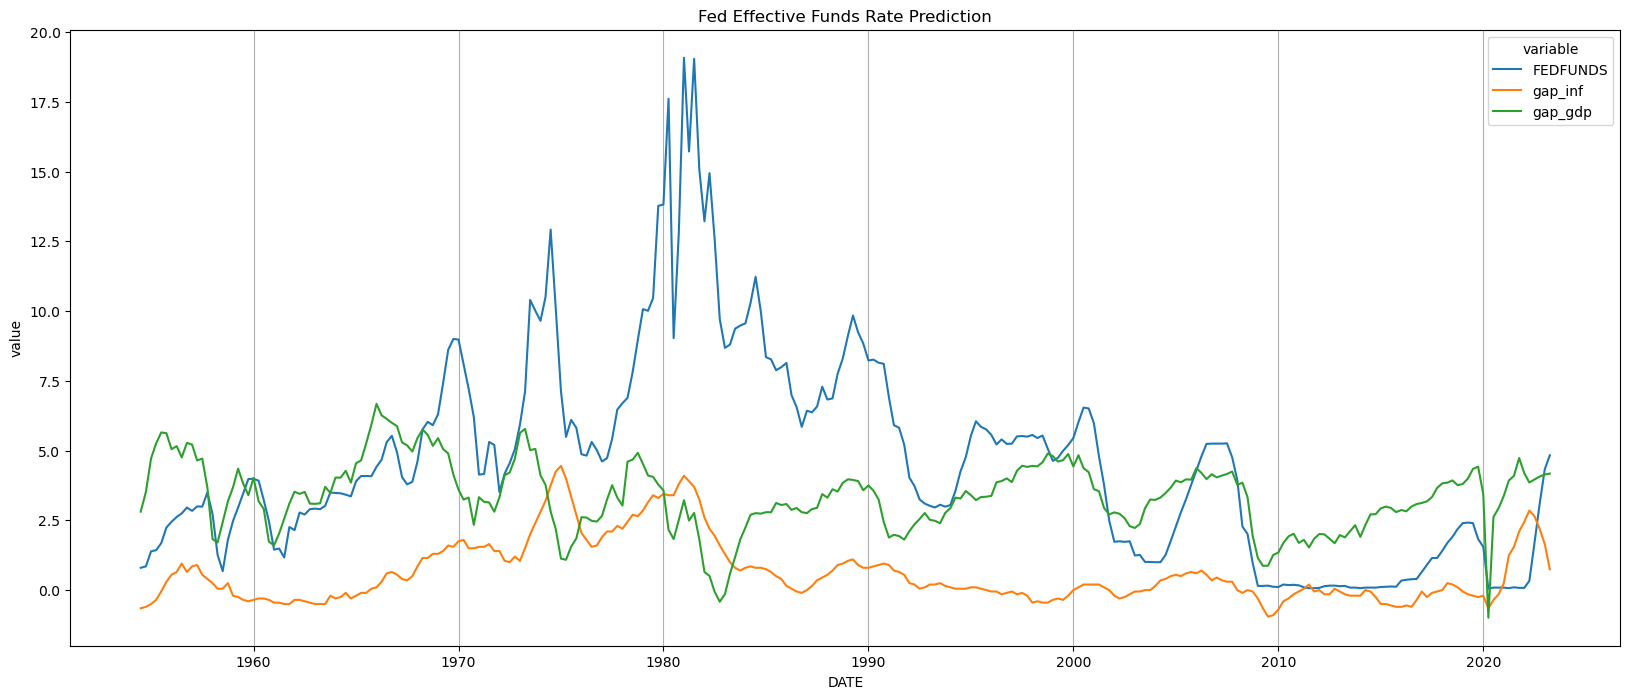

In [124]:
# Long 
long_df = taylor_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['DATE','FEDFUNDS','gap_inf','gap_gdp']].melt(id_vars=['DATE'])
print('long_df:', long_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
#ax.plot(long_df['observation_date'], long_df['value'], color='variable')
sns.lineplot(x = 'DATE', y = 'value', data=long_df, hue='variable')

ax.set(title='Fed Effective Funds Rate Prediction');

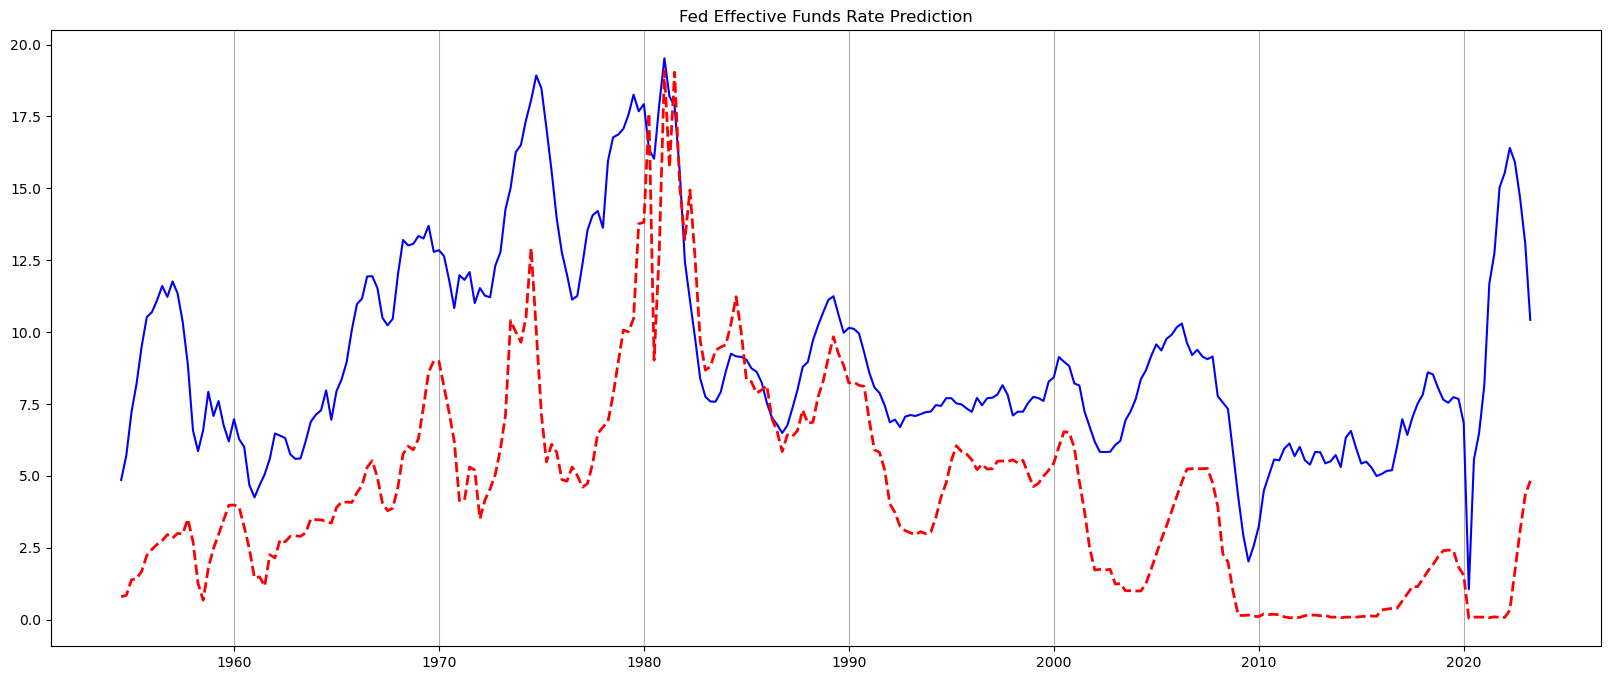

In [125]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'blue')
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

# Misery Index

In [126]:
m_df = pd.read_csv('./data/Misery Index from the Misery Index Database.csv', parse_dates=['Time'],skiprows=8, nrows=915)
m_df

,Time,EDI
0,1948-01-01,14.2326
1,1948-02-01,14.0023
2,1948-03-01,11.3493
3,1948-04-01,12.6758
4,1948-05-01,12.5324
...,...,...
900,2023-01-01,10.3101
901,2023-02-01,9.9356
902,2023-03-01,8.5850
903,2023-04-01,8.0303


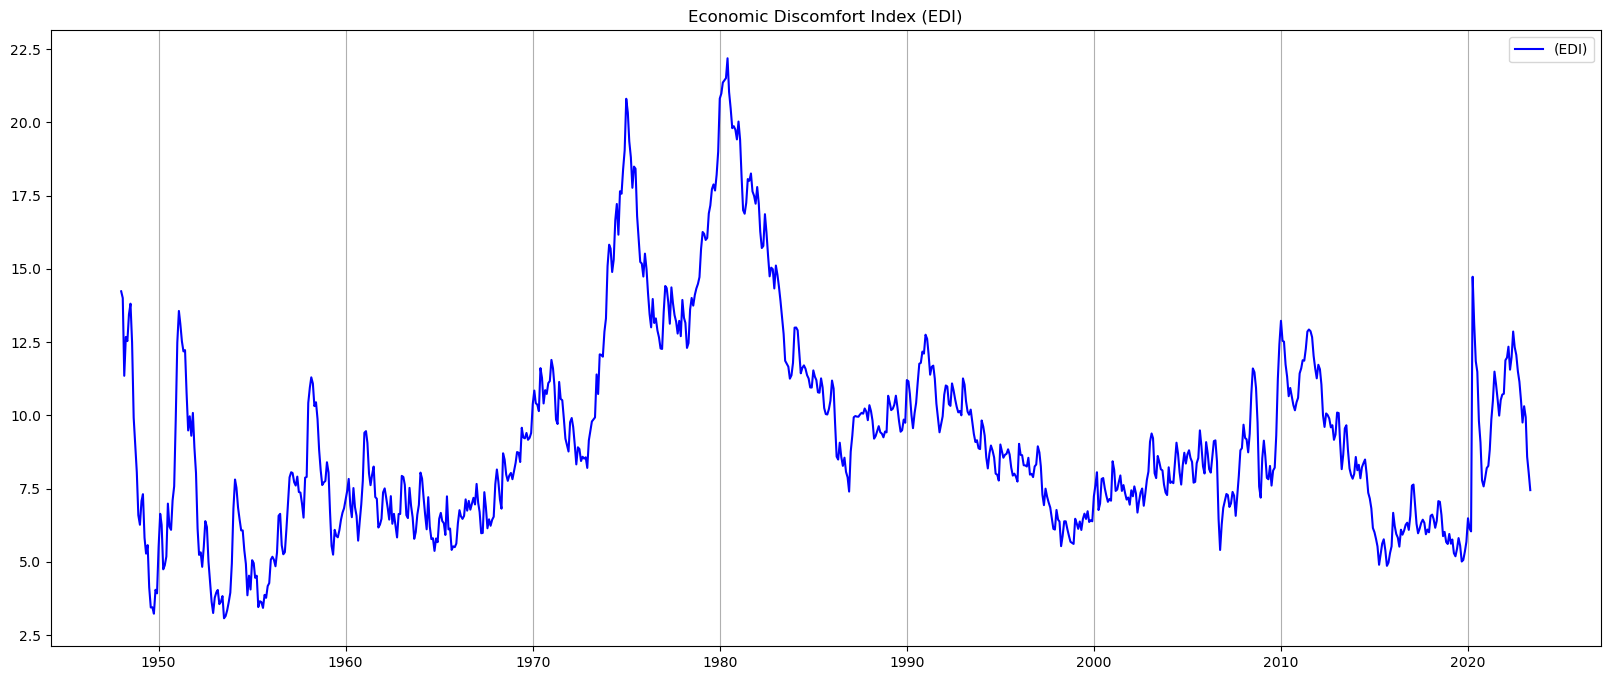

In [127]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(m_df['Time'], m_df['EDI'], 'blue')


ax.legend(["(EDI)"])

ax.set(title='Economic Discomfort Index (EDI)');

In [128]:
misery_df = load_misery()

t_df: (831, 3)
u_df: (909, 1)
misery_df: (831, 5)


In [129]:
misery_df.tail(50)

,FEDFUNDS,CPIAUCSL,UNRATE,CPIAUCSL_PC1,m_index
DATE,,,,,
2019-08-01,2.13,256.059,3.7,1.74678,5.44678
2019-09-01,2.04,256.511,3.5,1.71662,5.21662
2019-10-01,1.83,257.244,3.6,1.76918,5.36918
2019-11-01,1.55,257.803,3.6,2.06220,5.66220
2019-12-01,1.55,258.616,3.6,2.31399,5.91399
2020-01-01,1.55,259.037,3.5,2.50042,6.00042
2020-02-01,1.58,259.248,3.5,2.33932,5.83932
2020-03-01,0.65,258.124,4.4,1.54287,5.94287
2020-04-01,0.05,256.092,14.7,0.34520,15.04520


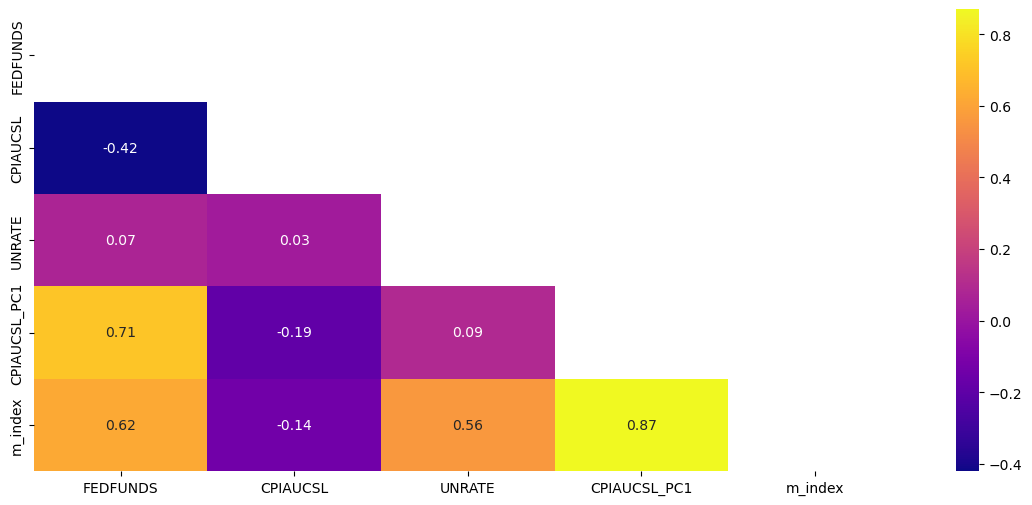

In [130]:
plt.figure(figsize=(14,6))
mask = np.zeros_like(misery_df.corr())
mask[np.triu_indices_from(mask)] = True
_p = sns.heatmap(misery_df.corr().round(2), annot=True, mask=mask, cmap="plasma")

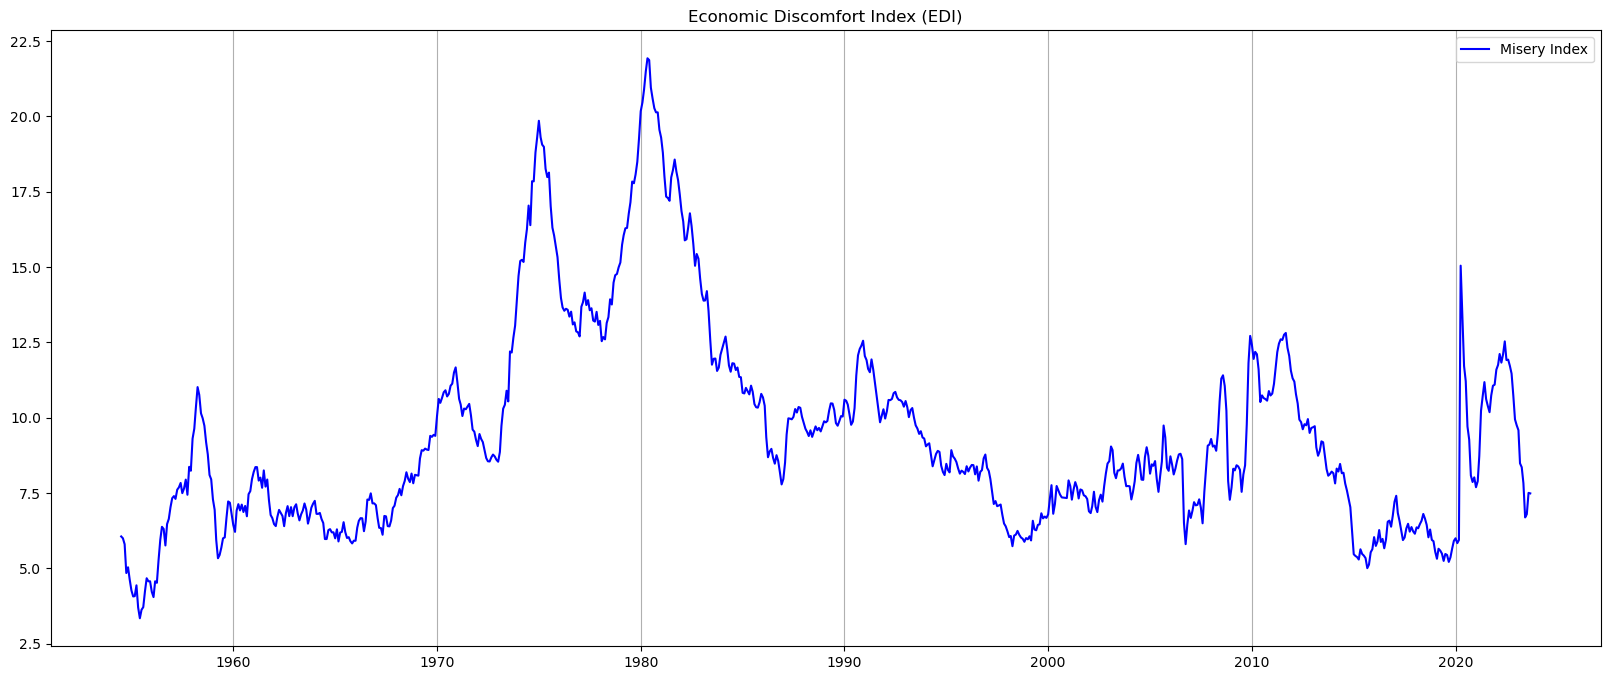

In [131]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(misery_df.index, misery_df['m_index'], 'blue')
#ax.plot(m_df['Time'], m_df['EDI'], 'red')

ax.legend(["Misery Index"])

ax.set(title='Economic Discomfort Index (EDI)');

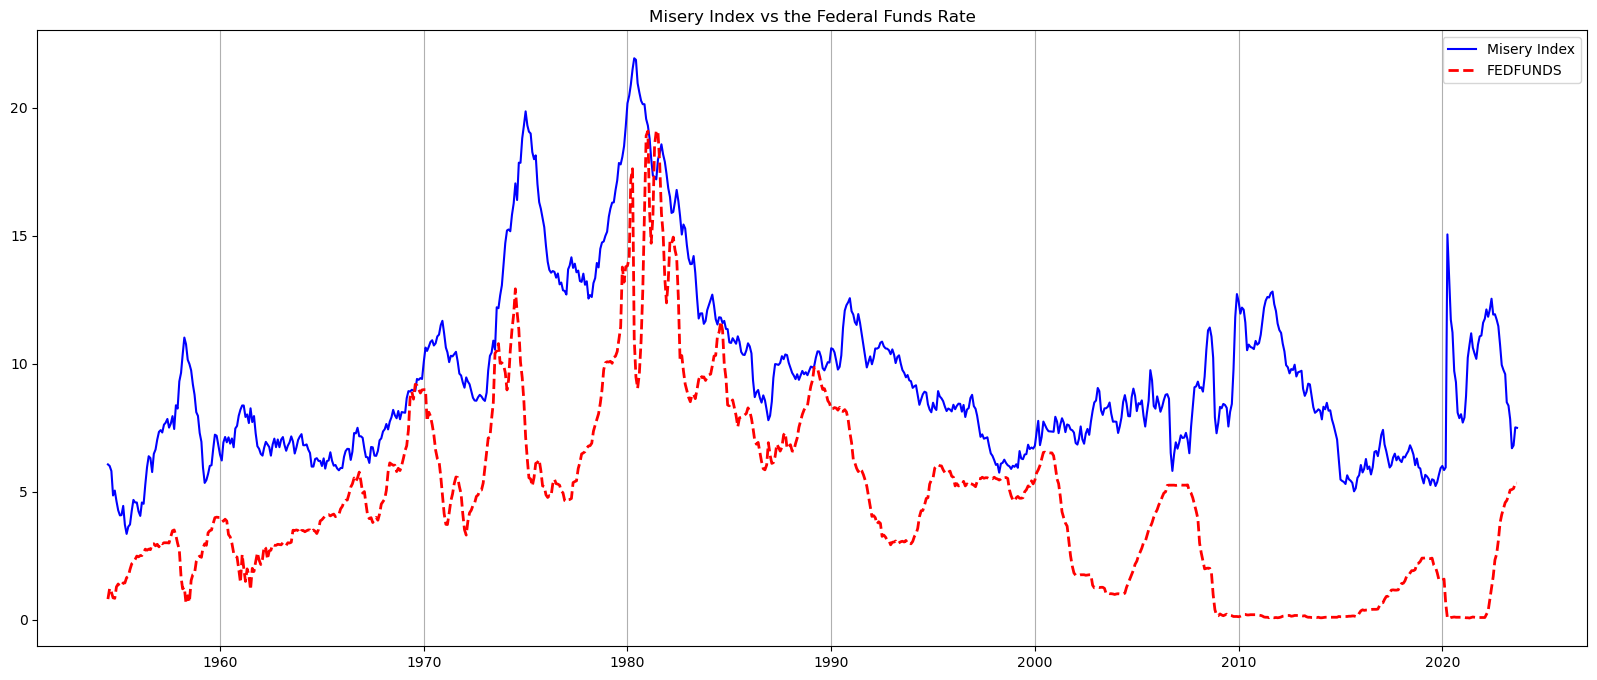

In [132]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(misery_df.index, misery_df['m_index'], 'blue')
ax.plot(misery_df.index, misery_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.legend(["Misery Index","FEDFUNDS"])

ax.set(title='Misery Index vs the Federal Funds Rate');

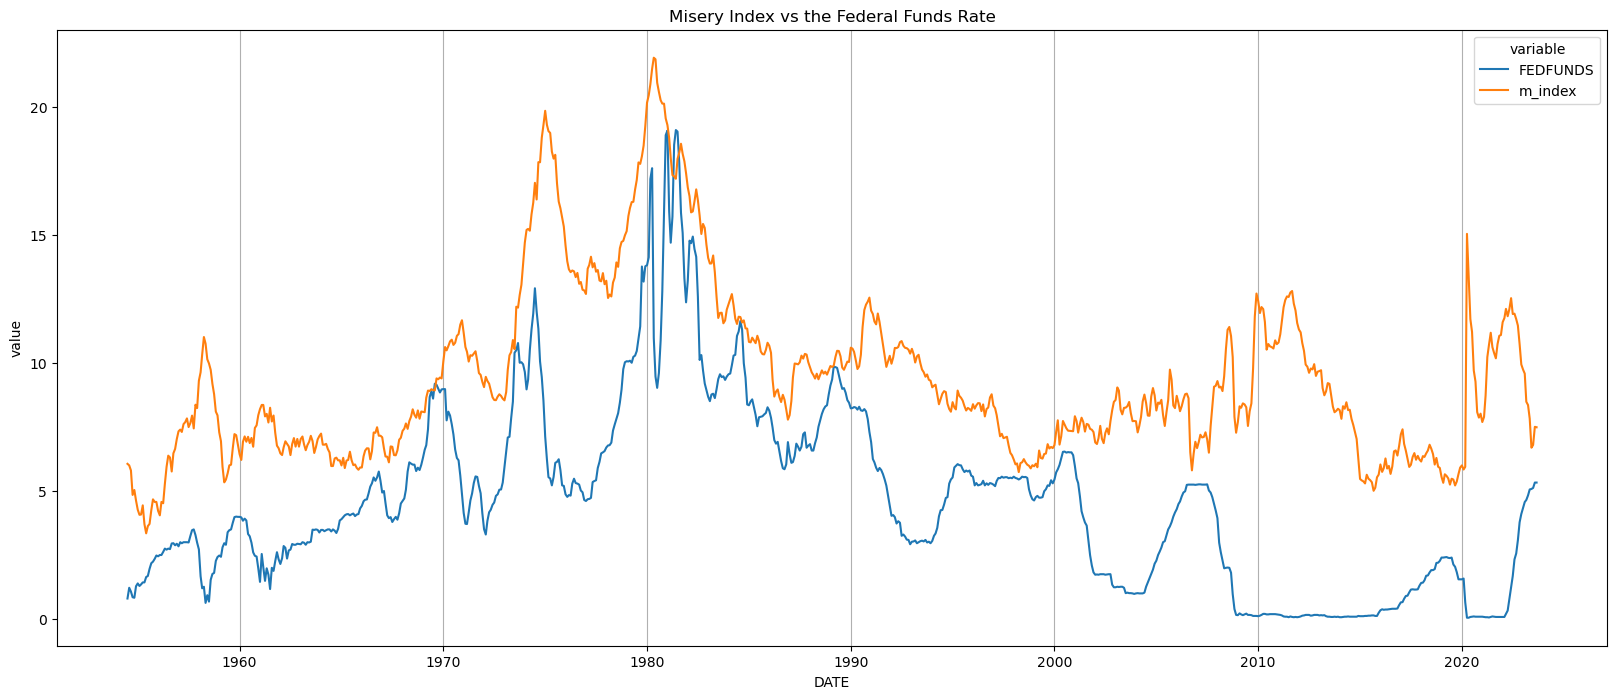

In [133]:
long_df = misery_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['DATE','FEDFUNDS','m_index']].melt(id_vars=['DATE'])

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
sns.lineplot(data=long_df, x = 'DATE', y = 'value', hue='variable')
#ax.plot(taylor_df['observation_date'], taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Misery Index vs the Federal Funds Rate');

# Taylor Rule

<b> Variables </b>
- nominal funds rate - FEDFUNDS
- real interest rate - REAINTRATREARAT1MO
- inflation - CPIAUCSL
- real gpd - real
- target = 0.02

#  Federal Reserve Economic Data Service
data_source = 'fred'
unemployment_rate_code = 'UNRATE'
cpi_code = 'CORESTICKM157SFRBATL'
real_rate_code = 'REAINTRATREARAT1MO'

cpi_urban = 'CPIAUCSL'
inf_10y = 'T10YIEM'
ff_rate_code = 'EFFR'

#GDP GAP
p_gdp = 'GDPPOT'

In [134]:
t1_df = pdr.DataReader(['FEDFUNDS','REAINTRATREARAT1MO','CORESTICKM157SFRBATL','GDPC1','GDPPOT'], data_source, start_date)
#t1_df.dropna(inplace=True)
print('t1_df:', t1_df.shape)
t1_df.head(5)

t1_df: (862, 5)


,FEDFUNDS,REAINTRATREARAT1MO,CORESTICKM157SFRBATL,GDPC1,GDPPOT
DATE,,,,,
1947-01-01,NaN,NaN,NaN,2182.681,NaN
1947-04-01,NaN,NaN,NaN,2176.892,NaN
1947-07-01,NaN,NaN,NaN,2172.432,NaN
1947-10-01,NaN,NaN,NaN,2206.452,NaN
1948-01-01,NaN,NaN,NaN,2239.682,NaN


In [135]:
t2_df = pd.read_csv('./data/Holston_Laubach_Williams_real_time_estimates.csv', parse_dates=['Date'], skiprows=5)
t2_df.set_index('Date', inplace=True)
print('t2_df:', t2_df.shape)
t2_df.head(5)

t2_df: (250, 3)


,Growth_g,Real_Interest_Rate,Output_Gap
Date,,,
1961-01-01,4.828759,5.493491,-3.755573
1961-04-01,4.989798,5.682399,-3.407557
1961-07-01,4.923091,5.609036,-2.640213
1961-10-01,4.910719,5.592011,-1.931028
1962-01-01,4.767864,5.431519,-1.116593


In [136]:
f1_df = t1_df.merge(t2_df, how='outer', left_index=True, right_index=True)
f1_df.dropna(inplace=True)
f1_df.index.rename('DATE', inplace=True)
f1_df.head()

,FEDFUNDS,REAINTRATREARAT1MO,CORESTICKM157SFRBATL,GDPC1,GDPPOT,Growth_g,Real_Interest_Rate,Output_Gap
DATE,,,,,,,,
1982-01-01,13.22,2.464018,0.36879,7295.631,7202.119830,2.956000,2.966393,-3.849021
1982-04-01,14.94,8.803434,0.90752,7328.912,7255.183995,3.080303,3.046039,-4.753866
1982-07-01,12.59,7.161898,0.56243,7300.896,7309.422617,2.918558,2.946979,-5.089924
1982-10-01,9.71,2.752972,0.29105,7303.817,7365.185870,2.863820,2.839540,-5.658898
1983-01-01,8.68,4.469162,0.53839,7400.066,7421.653951,2.990278,2.990787,-5.548596


In [137]:
target_inf = 2
alpha = 0.5
beta = 0.5

In [138]:
f1_df['gap_gdp'] = alpha * (f1_df['GDPC1'] - f1_df['GDPPOT']) / f1_df['GDPPOT'] * 100
f1_df['gap_inf'] = beta * (f1_df['CORESTICKM157SFRBATL'] - target_inf)

f1_df['ffef_tr'] = f1_df['Real_Interest_Rate']  \
                        + f1_df['CORESTICKM157SFRBATL']  \
                        + f1_df['gap_gdp']  \
                        + f1_df['gap_inf']

f1_df.head()

,FEDFUNDS,REAINTRATREARAT1MO,CORESTICKM157SFRBATL,GDPC1,GDPPOT,Growth_g,Real_Interest_Rate,Output_Gap,gap_gdp,gap_inf,ffef_tr
DATE,,,,,,,,,,,
1982-01-01,13.22,2.464018,0.36879,7295.631,7202.119830,2.956000,2.966393,-3.849021,0.649192,-0.815605,3.168770
1982-04-01,14.94,8.803434,0.90752,7328.912,7255.183995,3.080303,3.046039,-4.753866,0.508106,-0.546240,3.915425
1982-07-01,12.59,7.161898,0.56243,7300.896,7309.422617,2.918558,2.946979,-5.089924,-0.058326,-0.718785,2.732298
1982-10-01,9.71,2.752972,0.29105,7303.817,7365.185870,2.863820,2.839540,-5.658898,-0.416615,-0.854475,1.859500
1983-01-01,8.68,4.469162,0.53839,7400.066,7421.653951,2.990278,2.990787,-5.548596,-0.145439,-0.730805,2.652933


In [139]:
f1_train_df, f1_test_df = time_split(f1_df)

train_df:  (133, 11)
test_df:  (33, 11)


In [140]:
model_results(f1_train_df['FEDFUNDS'], f1_train_df['ffef_tr'], f1_train_df.shape[0], 2 )

r-squared:  0.3015
adj r-squared 0.2962
mse:  7.7257
rmse:  2.7795
rmse:  2.7795083742589024


In [141]:
model_results(f1_test_df['FEDFUNDS'], f1_test_df['ffef_tr'], f1_test_df.shape[0], 2 )

r-squared:  -4.4247
adj r-squared -4.5997
mse:  8.3382
rmse:  2.8876
rmse:  2.8875953164565695


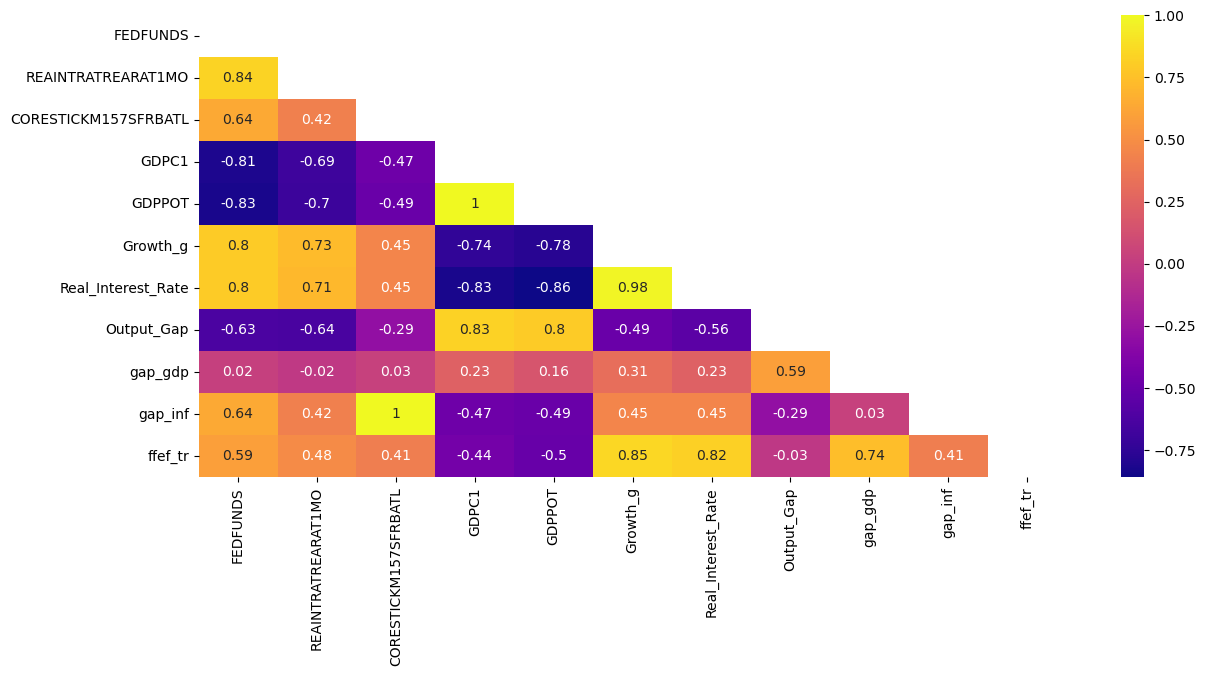

In [142]:
plt.figure(figsize=(14,6))
mask = np.zeros_like(f1_df.corr())
mask[np.triu_indices_from(mask)] = True
_p = sns.heatmap(f1_df.corr().round(2), annot=True, mask=mask, cmap="plasma")

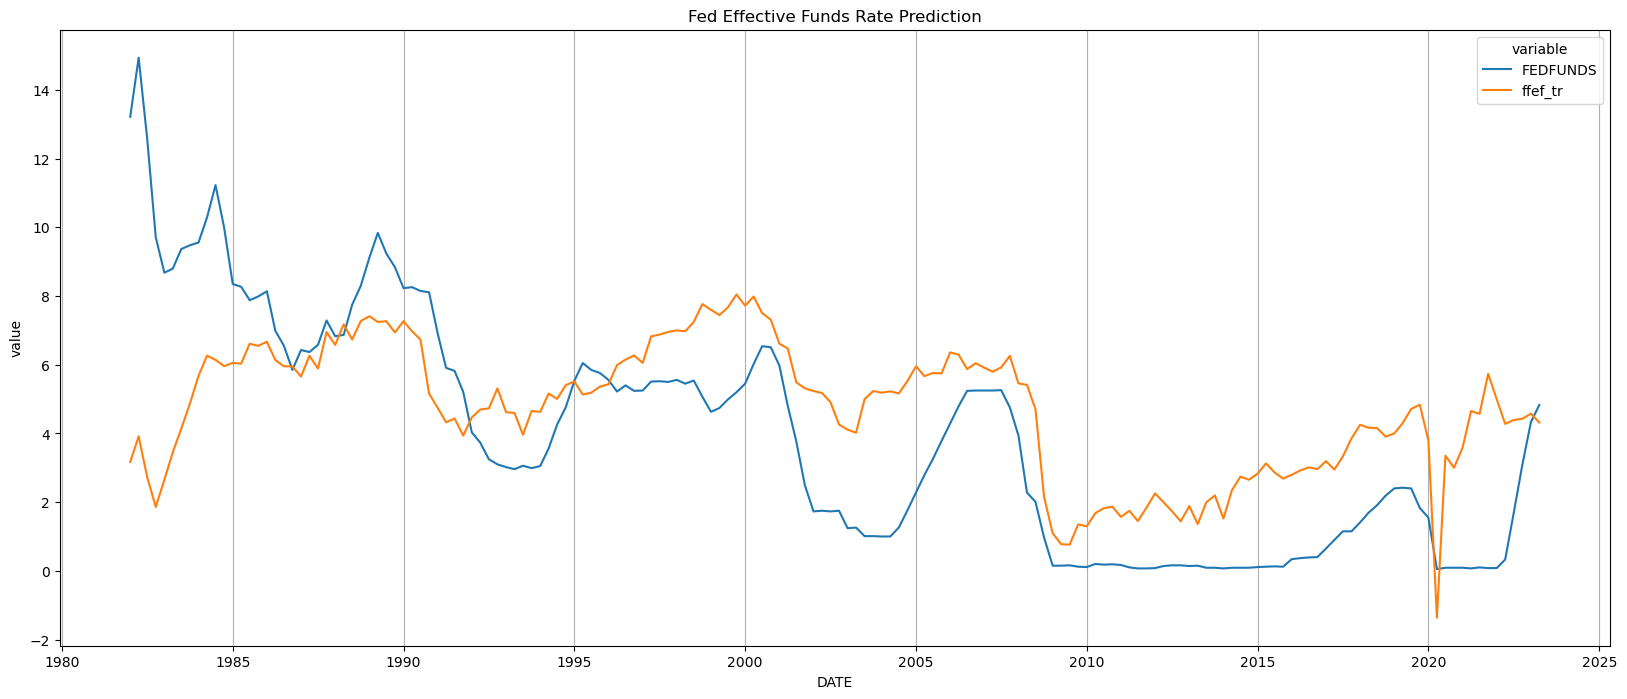

In [143]:
long_df = f1_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['DATE','FEDFUNDS','ffef_tr']].melt(id_vars=['DATE'])

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
sns.lineplot(data=long_df, x = 'DATE', y = 'value', hue='variable')
#ax.plot(taylor_df['observation_date'], taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

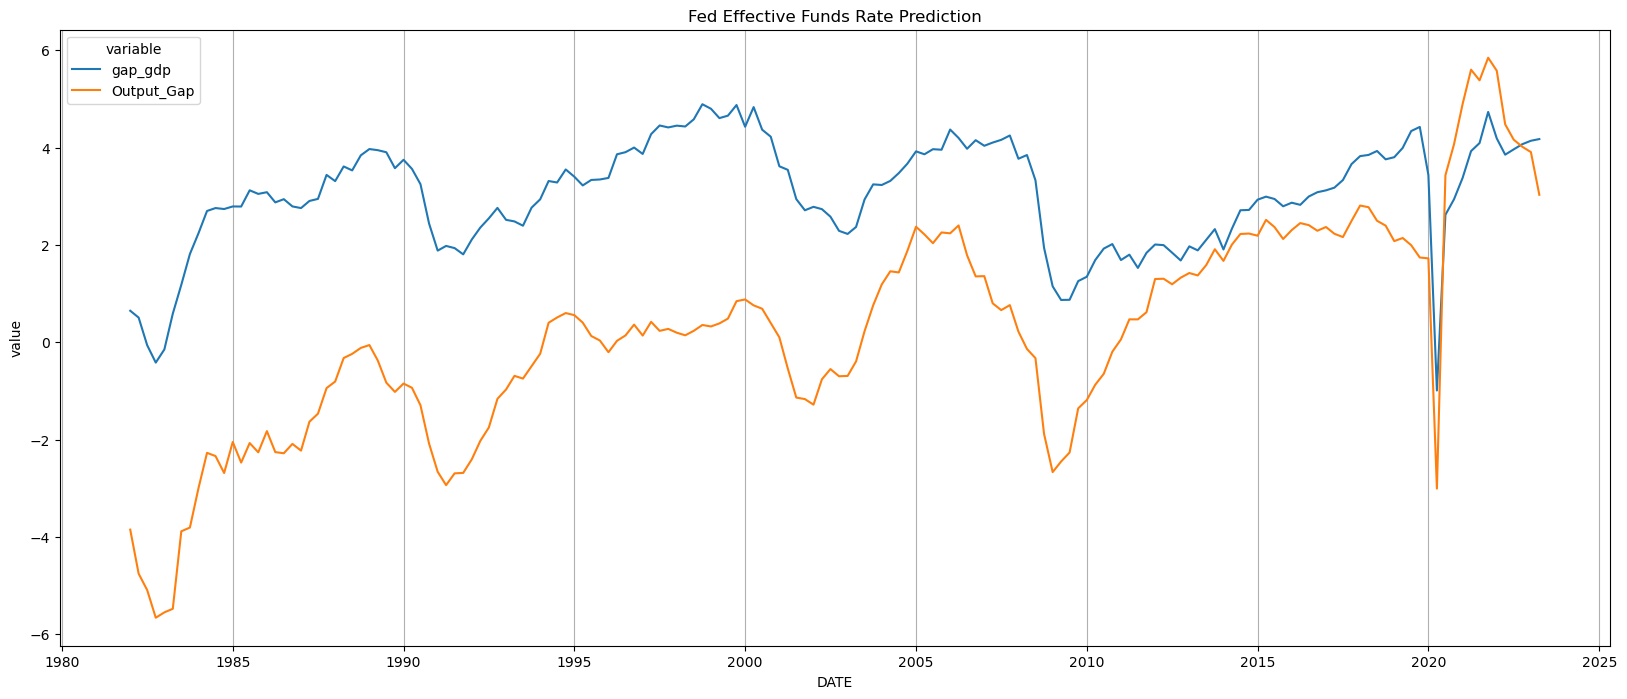

In [144]:
long_df = f1_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['DATE','gap_gdp','Output_Gap']].melt(id_vars=['DATE'])

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
sns.lineplot(data=long_df, x = 'DATE', y = 'value', hue='variable')
#ax.plot(taylor_df['observation_date'], taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

# Regression Models 

## Load Data

In [145]:
taylor_df = load_taylor()

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


In [146]:
test_df, train_df = time_split(taylor_df)

train_df:  (221, 7)
test_df:  (55, 7)


In [147]:
train_df

,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,ffef_tr,gap_inf,gap_gdp
DATE,,,,,,,
2009-10-01,16502.754,16097.706573,0.2,0.12,2.558090,-0.90,1.258090
2010-01-01,16582.710,16147.438323,0.6,0.11,3.247804,-0.70,1.347804
2010-04-01,16743.162,16195.753430,1.2,0.20,4.489976,-0.40,1.689976
2010-07-01,16872.266,16246.535505,1.4,0.18,5.025735,-0.30,1.925735
2010-10-01,16960.864,16302.486211,1.7,0.19,5.569256,-0.15,2.019256
2011-01-01,16920.632,16367.132381,1.9,0.17,5.540888,-0.05,1.690888
2011-04-01,17035.114,16442.754569,2.1,0.10,5.951278,0.05,1.801278
2011-07-01,17031.313,16526.001919,2.4,0.07,6.128836,0.20,1.528836
2011-10-01,17222.583,16611.843560,1.9,0.07,5.688265,-0.05,1.838265


In [148]:
X_train = train_df[['gap_inf', 'gap_gdp']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['gap_inf', 'gap_gdp']]
y_test = test_df['FEDFUNDS']

In [149]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
#cat_columns_lst = ['LineOfBusiness','Segment','Type','pay_plan','Revenue_Band','cc_indicator','Service_Center']
num_columns_lst = ['gap_inf', 'gap_gdp']
#ohe_categories = list()

numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

In [150]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        #("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [151]:
pipe_lg = Pipeline(
    steps = [ ('preprocessor',preprocessor),  
             ('model',  LinearRegression()) ]
)
param_lg = {}


pipe_lasso = Pipeline( steps = [('preprocessor',preprocessor), ('model',Lasso())])
param_lasso = {'model__alpha': np.linspace(0.000001, 0.001, 50)}


pipe_knn = Pipeline(steps = [('preprocessor',preprocessor), ('model',KNeighborsRegressor())])
param_knn = {'model__n_neighbors': randint(3, 10)}


pipe_dt = Pipeline(steps = [('preprocessor',preprocessor), ('model',DecisionTreeRegressor())])
param_dt = {'model__max_leaf_nodes': randint(20, 150),
            'model__max_depth': randint(10, 40),
}

pipe_ada = Pipeline(
    steps = [('preprocessor',preprocessor), ('model',AdaBoostRegressor())]
)
param_ada = {'model__n_estimators': randint(100, 150)}


pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)
param_ltb = {
    'model__max_depth': randint(3, 20),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__verbose': [-1],
    'model__eval_metric': ['auc'],
}


pipe_xgb = Pipeline(
    steps = [('preprocessor',preprocessor), ('model',xgb.XGBRegressor(tree_method="hist", objective='binary:logistic'))]
)

param_xgb = {
    'model__max_depth': randint(3, 15),
    'model__num_leaves': randint(3, 15),
    'model__error_score' : ['raise'],
    'model__scale_pos_weight' : randint(3, 10)
}

In [152]:
pipe_dict = {'lg':pipe_lg, 'knn':pipe_knn, 'dt':pipe_dt, 'ada':pipe_ada, 'ltb':pipe_ltb, 'xgb':pipe_dt}
param_dict = {'lg':param_lg, 'knn':param_knn, 'dt':param_dt, 'ada':param_ada, 'ltb':param_ltb, 'xgb':param_dt}

#pipe_dict = {'ada':pipe_ada}
#param_dict = {'ada':param_ada}

#pipe_dict = {'ltb':pipe_ltb}
#param_dict = {'ltb':param_ltb}

#pipe_dict = {'xgb':pipe_dt}
#param_dict = {'xgb':param_dt}

lg ) Best Accuracy Score: -39.21688982924532 Parameters: {} {}
knn ) Best Accuracy Score: -1.3230404592742249 Parameters: {} {'model__n_neighbors': 3}
dt ) Best Accuracy Score: -0.8418334430788972 Parameters: {} {'model__max_depth': 21, 'model__max_leaf_nodes': 23}
ada ) Best Accuracy Score: -4.326201239155978 Parameters: {} {'model__n_estimators': 102}
ltb ) Best Accuracy Score: -1.4788094540892796 Parameters: {} {'model__eval_metric': 'auc', 'model__max_depth': 8, 'model__min_data_in_leaf': 19, 'model__num_leaves': 37, 'model__verbose': -1}
xgb ) Best Accuracy Score: -0.8418334430788971 Parameters: {} {'model__max_depth': 21, 'model__max_leaf_nodes': 23}


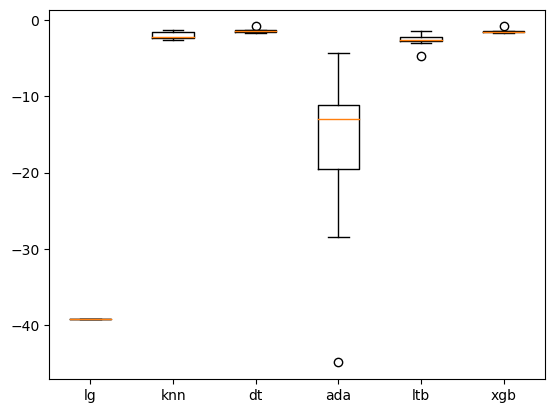

In [153]:
results_lst = []
model_dct = {}

for name, p in pipe_dict.items():
    cv = RandomizedSearchCV(estimator = p, param_distributions = param_dict[name]
                            , random_state=rand_int, scoring="r2")
    cv.fit(X_train, y_train)
    
    cv_results = cv.cv_results_['mean_test_score']
    results_lst.append(cv_results)
    
    model_dct[name] = cv
    print(name, ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)
    
plt.boxplot(results_lst, labels=pipe_dict.keys())
plt.show()

# Stats Model - Missery Index

In [154]:
misery_df = load_misery()

t_df: (831, 3)
u_df: (909, 1)
misery_df: (831, 5)


In [155]:
train_df, test_df = time_split(misery_df)

train_df:  (665, 5)
test_df:  (166, 5)


In [156]:
misery_df.describe()

,FEDFUNDS,CPIAUCSL,UNRATE,CPIAUCSL_PC1,m_index
count,831.000000,831.000000,831.000000,831.000000,831.000000
mean,4.599037,128.531264,5.857762,3.592631,9.450392
std,3.598657,82.608377,1.666064,2.817321,3.399739
min,0.050000,26.710000,3.400000,-1.958760,3.346250
25%,1.780000,40.950000,4.600000,1.695205,7.023160
50%,4.160000,121.600000,5.600000,2.900550,8.561790
75%,6.245000,201.550000,6.900000,4.470950,10.796125
max,19.100000,307.481000,14.700000,14.592270,21.925770


In [157]:
X_train = train_df[['UNRATE', 'CPIAUCSL_PC1']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['UNRATE', 'CPIAUCSL_PC1']]
y_test = test_df['FEDFUNDS']

In [158]:
X_train_const = sm.add_constant(X_train)

In [159]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

In [160]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     469.7
Date:                Sun, 29 Oct 2023   Prob (F-statistic):          1.05e-127
Time:                        18:07:31   Log-Likelihood:                -1459.3
No. Observations:                 665   AIC:                             2925.
Df Residuals:                     662   BIC:                             2938.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.5544      0.346      4.492      0.000       0.875       2.234
UNRATE           0.1059      0.059      1.802      0.072      -0.009       0.221
CPIAUCSL_PC1     0.8718      0.030     29.414      0.000       0.814       0.930
==============================================================================
Omnibus:                       16.889   Durbin-Watson:                   0.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.600
Skew:                           0.275   Prob(JB):                     2.04e-05
Kurtosis:                       3.691   Cond. No.                         30.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [161]:
t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)
train_pred_ols

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
DATE,,,,,,
1954-07-01,2.396224,0.135621,2.129924,2.662524,-1.885675,6.678123
1954-08-01,2.189596,0.144227,1.906399,2.472794,-2.093387,6.472580
1954-09-01,1.940805,0.153013,1.640356,2.241254,-2.343354,6.224963
1954-10-01,1.413793,0.161815,1.096062,1.731525,-2.871612,5.699199
1954-11-01,1.888199,0.145817,1.601880,2.174518,-2.394992,6.171390
...,...,...,...,...,...,...
2009-07-01,0.852409,0.316294,0.231348,1.473469,-3.466093,5.170911
2009-08-01,1.277044,0.311472,0.665451,1.888636,-3.040107,5.594194
2009-09-01,1.390543,0.319190,0.763795,2.017290,-2.928781,5.709866


In [162]:
model_results(y_train, train_pred_ols['mean'], X_train.shape[0], 2 )

r-squared:  0.5866
adj r-squared 0.586
mse:  4.7156
rmse:  2.1716
rmse:  2.171552120508911


In [163]:
X_test_const = sm.add_constant(X_test)

In [164]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)

In [165]:
model_results(y_test, test_pred_ols['mean'], X_train.shape[0], 2 )

r-squared:  -8.7292
adj r-squared -8.7438
mse:  15.9319
rmse:  3.9915
rmse:  3.9914790557803825


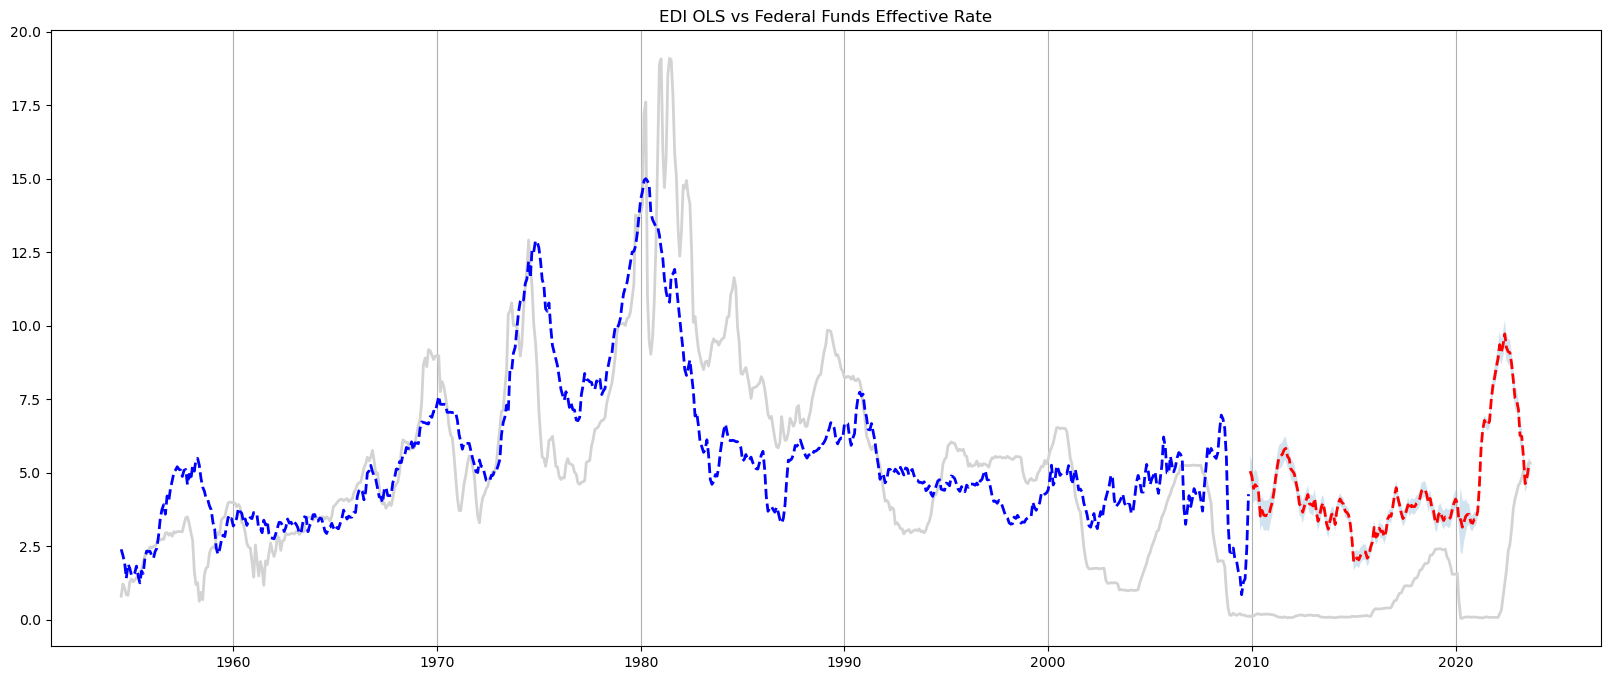

In [166]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(misery_df.index, misery_df['m_index'], 'orange', linestyle='--', linewidth=1)

#ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='EDI OLS vs Federal Funds Effective Rate');

# Stats Model - Taylor Rule

In [167]:
taylor_df = load_taylor()

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


In [168]:
taylor_df

,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,ffef_tr,gap_inf,gap_gdp
DATE,,,,,,,
1954-07-01,2880.482,2727.099666,0.7,0.80,4.862188,-0.65,2.812188
1954-10-01,2936.852,2743.726730,0.8,0.85,5.719397,-0.60,3.519397
1955-01-01,3020.746,2760.136280,1.0,1.39,7.220957,-0.50,4.720957
1955-04-01,3069.910,2777.950765,1.3,1.43,8.204939,-0.35,5.254939
1955-07-01,3111.379,2795.471543,1.9,1.68,9.500343,-0.05,5.650343
...,...,...,...,...,...,...,...
2022-04-01,21708.160,20153.810000,7.7,0.33,16.406219,2.85,3.856219
2022-07-01,21851.134,20245.660000,7.3,1.68,15.914983,2.65,3.964983
2022-10-01,21989.981,20334.210000,6.4,3.08,14.671392,2.20,4.071392


In [169]:
train_df, test_df = time_split(taylor_df)

train_df:  (221, 7)
test_df:  (55, 7)


In [170]:
train_df

,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,ffef_tr,gap_inf,gap_gdp
DATE,,,,,,,
1954-07-01,2880.482,2727.099666,0.7,0.80,4.862188,-0.65,2.812188
1954-10-01,2936.852,2743.726730,0.8,0.85,5.719397,-0.60,3.519397
1955-01-01,3020.746,2760.136280,1.0,1.39,7.220957,-0.50,4.720957
1955-04-01,3069.910,2777.950765,1.3,1.43,8.204939,-0.35,5.254939
1955-07-01,3111.379,2795.471543,1.9,1.68,9.500343,-0.05,5.650343
...,...,...,...,...,...,...,...
2008-07-01,16854.295,15801.953968,2.0,2.01,7.329781,0.00,3.329781
2008-10-01,16485.350,15869.009828,1.9,0.97,5.791962,-0.05,1.941962
2009-01-01,16298.262,15931.698339,1.4,0.15,4.250422,-0.30,1.150422


## Training

In [171]:
X_train = train_df[['gap_inf','gap_gdp']]
X_train_const = sm.add_constant(X_train)
X_train_const

,const,gap_inf,gap_gdp
DATE,,,
1954-07-01,1.0,-0.65,2.812188
1954-10-01,1.0,-0.60,3.519397
1955-01-01,1.0,-0.50,4.720957
1955-04-01,1.0,-0.35,5.254939
1955-07-01,1.0,-0.05,5.650343
...,...,...,...
2008-07-01,1.0,0.00,3.329781
2008-10-01,1.0,-0.05,1.941962
2009-01-01,1.0,-0.30,1.150422


In [172]:
y_train = train_df['FEDFUNDS']
y_train

DATE
1954-07-01    0.80
1954-10-01    0.85
1955-01-01    1.39
1955-04-01    1.43
1955-07-01    1.68
              ... 
2008-07-01    2.01
2008-10-01    0.97
2009-01-01    0.15
2009-04-01    0.15
2009-07-01    0.16
Name: FEDFUNDS, Length: 221, dtype: float64

In [173]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

In [174]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     124.8
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           7.64e-37
Time:                        18:07:31   Log-Likelihood:                -501.40
No. Observations:                 221   AIC:                             1009.
Df Residuals:                     218   BIC:                             1019.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1748      0.498      8.377      0.000       3.193       5.157
gap_inf        2.1654      0.140     15.504      0.000       1.890       2.441
gap_gdp       -0.0670      0.128     -0.523      0.601      -0.319       0.185
==============================================================================
Omnibus:                        1.474   Durbin-Watson:                   0.248
Prob(Omnibus):                  0.479   Jarque-Bera (JB):                1.165
Skew:                           0.157   Prob(JB):                        0.559
Kurtosis:                       3.165   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [175]:
(0.7119 - 0.2770) / 0.2770

1.5700361010830322

In [176]:
train_pred = ols_result.predict(X_train_const)
train_pred

DATE
1954-07-01    2.579000
1954-10-01    2.639909
1955-01-01    2.775983
1955-04-01    3.065033
1955-07-01    3.688174
                ...   
2008-07-01    3.951849
2008-10-01    3.936519
2009-01-01    3.448176
2009-04-01    2.709011
2009-07-01    2.059168
Length: 221, dtype: float64

In [177]:
t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)
train_pred_ols

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
DATE,,,,,,
1954-07-01,2.579000,0.274621,2.037748,3.120251,-2.094525,7.252524
1954-10-01,2.639909,0.244934,2.157167,3.122652,-2.027201,7.307020
1955-01-01,2.775983,0.268072,2.247638,3.304328,-1.896065,7.448030
1955-04-01,3.065033,0.298705,2.476314,3.653752,-1.614226,7.744293
1955-07-01,3.688174,0.324100,3.049404,4.326945,-0.997645,8.373994
...,...,...,...,...,...,...
2008-07-01,3.951849,0.191934,3.573564,4.330133,-0.705616,8.609314
2008-10-01,3.936519,0.287736,3.369418,4.503619,-0.740070,8.613108
2009-01-01,3.448176,0.385524,2.688345,4.208008,-1.255676,8.152028


In [178]:
model_results(y_train, train_pred_ols['mean'], X_train.shape[0], 2 )

r-squared:  0.5337
adj r-squared 0.5316
mse:  5.4721
rmse:  2.3393
rmse:  2.3392607380473445


## Test

In [179]:
X_test = test_df[['gap_inf','gap_gdp']]
X_test_const = sm.add_constant(X_test)
X_test_const.shape

(55, 3)

In [180]:
y_test = test_df['FEDFUNDS']
y_test.shape

(55,)

test_pred_ols = ols_result.predict(X_test_const)
test_pred_ols

In [181]:
X_test.shape[0]

55

In [182]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(55, 6)

In [183]:
model_results(y_test, test_pred_ols['mean'], X_test.shape[0], 2 )

r-squared:  -12.5897
adj r-squared -12.8461
mse:  16.0893
rmse:  4.0111
rmse:  4.01114669848792


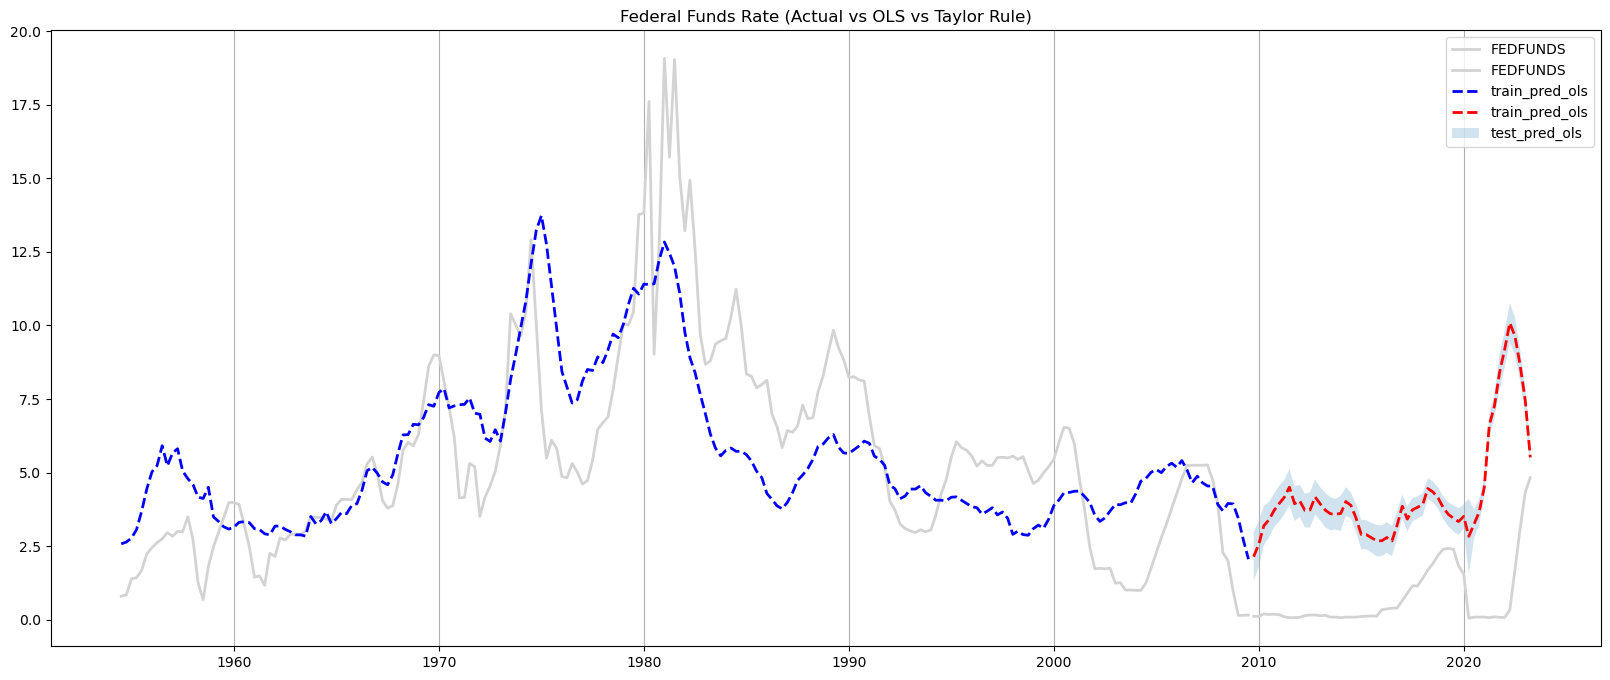

In [184]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

In [185]:
pd.DataFrame(y_test).describe()

,FEDFUNDS
count,55.000000
mean,0.747091
std,1.098117
min,0.050000
25%,0.090000
50%,0.160000
75%,1.150000
max,4.830000


In [186]:
pd.DataFrame(test_pred_ols).describe()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,4.293708,0.266242,3.768970,4.818446,-0.380269,8.967685
std,1.864330,0.076579,1.874158,1.866693,1.865798,1.863153
min,2.141724,0.173972,1.307916,2.975533,-2.574642,6.858091
25%,3.366661,0.217234,2.834632,3.877128,-1.306398,8.039720
50%,3.726662,0.260219,3.221008,4.256519,-0.954013,8.403035
75%,4.166474,0.300819,3.680144,4.722793,-0.513350,8.846299
max,10.087991,0.651774,9.409206,10.766777,5.396549,14.779433


# Linear Regression

In [187]:
taylor_df = load_taylor()

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


In [188]:
train_df, test_df = time_split(taylor_df)

train_df:  (221, 7)
test_df:  (55, 7)


In [189]:
X_train = train_df[['gap_inf','gap_gdp']]

In [190]:
y_train = train_df['FEDFUNDS']
y_train

DATE
1954-07-01    0.80
1954-10-01    0.85
1955-01-01    1.39
1955-04-01    1.43
1955-07-01    1.68
              ... 
2008-07-01    2.01
2008-10-01    0.97
2009-01-01    0.15
2009-04-01    0.15
2009-07-01    0.16
Name: FEDFUNDS, Length: 221, dtype: float64

In [191]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.5337118411665726

In [192]:
#reg.get_params()

In [193]:
train_pred_lm = reg.predict(X_train)

In [194]:
model_results(y_train, train_pred_lm, X_train.shape[0], 2 )

r-squared:  0.5337
adj r-squared 0.5316
mse:  5.4721
rmse:  2.3393
rmse:  2.3392607380473445


## Test

In [195]:
X_test = test_df[['gap_inf','gap_gdp']]
X_test.shape

(55, 2)

In [196]:
y_test = test_df['FEDFUNDS']
y_test.shape

(55,)

In [197]:
test_pred_lm = reg.predict(X_test)
test_pred_lm.shape

(55,)

In [198]:
model_results(y_test, test_pred_lm, X_test.shape[0], 2 )

r-squared:  -12.5897
adj r-squared -12.8461
mse:  16.0893
rmse:  4.0111
rmse:  4.011146698487923


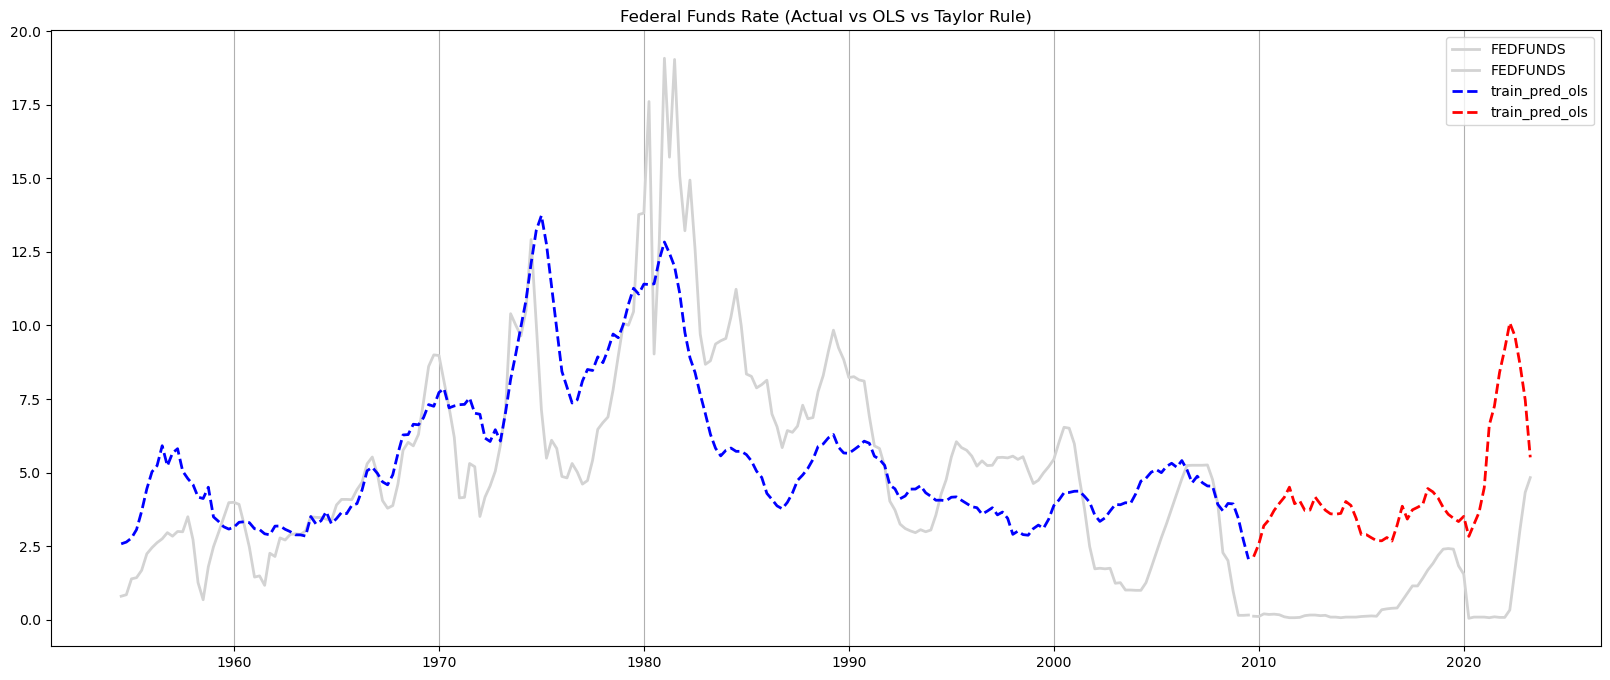

In [199]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# LGBM

In [200]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train, y_train)
train_pred_lgbm = ltb_model.predict(X_train, pred_contrib=False, raw_score=False)

<Axes: >

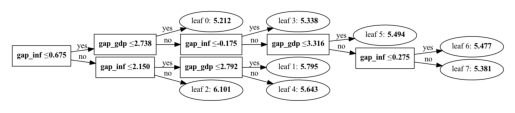

In [201]:
ltb.plot_tree(ltb_model)

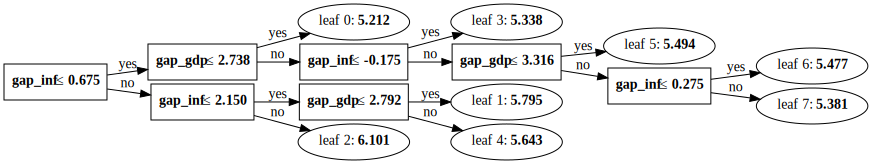

In [202]:
ltb.create_tree_digraph(ltb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

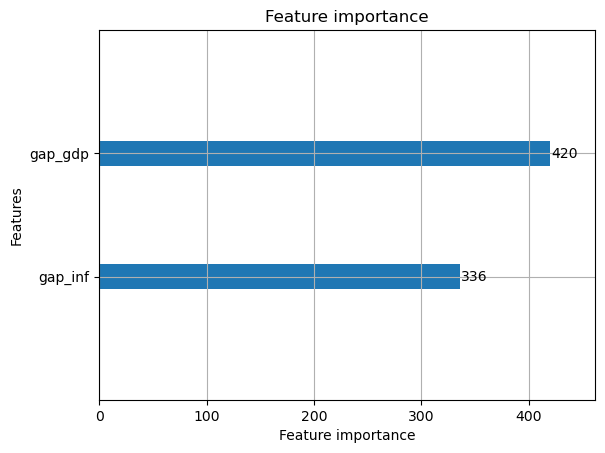

In [203]:
ltb.plot_importance(ltb_model)

In [204]:
model_results(y_train, train_pred3, X_train.shape[0], 2 )

NameError: name 'train_pred3' is not defined

## Test

In [ ]:
test_pred_lgbm = ltb_model.predict(X_test, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

In [ ]:
model_results(y_test, test_pred_lgbm, X_train.shape[0], 2 )

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# XGB

In [ ]:
xgb_model = xgb.XGBRegressor(verbose=-1).fit(X_train, y_train)
train_pred_xgb = xgb_model.predict(X_train)
xgb_model.score(X_train, y_train)

In [ ]:
model_results(y_train, train_pred_xgb, X_train.shape[0], 2 )

In [ ]:
xgb.plot_importance(xgb_model)

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(xgb_model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

fig.show()

## Test

In [ ]:
test_pred_xgb = xgb_model.predict(X_test)
test_pred_xgb.shape

In [ ]:
model_results(y_test, test_pred_xgb, X_train.shape[0], 2 )

# AdaBoostRegressor

In [ ]:
ada_model = AdaBoostRegressor().fit(X_train, y_train)
train_pred_ada = ada_model.predict(X_train)

In [ ]:
model_results(y_train, train_pred5, X_train.shape[0], 2 )

In [ ]:
test_pred_ada = ada_model.predict(X_test)

In [ ]:
model_results(y_test, test_pred_ada, X_test.shape[0], 2 )

# Pre 2006

In [ ]:
taylor2006_df = load_taylor()
taylor2006_df = taylor2006_df.query('index < "2007-01-01"')
taylor2006_df

In [ ]:
train2006_df, test2006_df = time_split(taylor2006_df)

## OLS

In [ ]:
X_train = train2006_df[['gap_inf','gap_gdp']]
X_train_const = sm.add_constant(X_train)
X_train_const

In [ ]:
y_train = train2006_df['FEDFUNDS']
y_train

In [ ]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

In [ ]:
ols_result.summary()

In [ ]:
t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)
train_pred_ols

In [ ]:
model_results(y_train, train_pred_ols['mean'], X_train.shape[0], 2 )

## Test

In [ ]:
X_test = test2006_df[['gap_inf','gap_gdp']]
X_test_const = sm.add_constant(X_test)
X_test_const.shape

In [ ]:
y_test = test2006_df['FEDFUNDS']
y_test.shape

In [ ]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

In [ ]:
model_results(y_test, test_pred_ols['mean'], X_test.shape[0], 2 )

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train2006_df.index, train2006_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test2006_df.index, test2006_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# LGBM

In [ ]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train, y_train)
train_pred_lgbm = ltb_model.predict(X_train, pred_contrib=False, raw_score=False)

In [ ]:
ltb.plot_tree(ltb_model)

In [ ]:
ltb.create_tree_digraph(ltb_model)

In [ ]:
ltb.plot_importance(ltb_model)

In [ ]:
model_results(y_train, train_pred_lgbm, X_train.shape[0], 2 )

## Test

In [ ]:
test_pred_lgbm = ltb_model.predict(X_test, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

In [ ]:
model_results(y_test, test_pred_lgbm, X_train.shape[0], 2 )

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train2006_df.index, train2006_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test2006_df.index, test2006_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# tsa.SARIMAX

In [ ]:
taylor2006_df = load_taylor()
taylor2006_df = taylor2006_df.query('index < "2007-01-01"')
taylor2006_df

In [ ]:
train2006_df, test2006_df = time_split(taylor2006_df)

In [ ]:
model_results(train2006_df['FEDFUNDS'], train2006_df['ffef_tr'], f1_train_df.shape[0], 2 )

In [ ]:
model_results(test2006_df['FEDFUNDS'], test2006_df['ffef_tr'], f1_test_df.shape[0], 2 )

In [ ]:
X_train = train2006_df[['gap_inf','gap_gdp']]
y_train = train2006_df['FEDFUNDS']

In [ ]:
model = sm.tsa.SARIMAX(y_train, exog=X_train)

In [ ]:
result_model = model.fit(disp=False)

In [ ]:
result_model.summary()

In [ ]:
train_result = result_model.get_prediction(start=-len(X_train), dynamic=True)

In [ ]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

## Test

In [ ]:
X_test = test2006_df[['gap_inf','gap_gdp']]
y_test = test2006_df['FEDFUNDS']

In [ ]:
s_idx = len(X_train)
e_idx = s_idx + len(X_test) - 1

In [ ]:
test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test, dynamic=True)

In [ ]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

In [ ]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train2006_df.index, train2006_df['FEDFUNDS'], 'gray')
ax.plot(test2006_df.index, test2006_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [ ]:
print('SARIMAX RMSE(Train):' , statsmodels.tools.eval_measures.rmse(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX RMSE(Test):' , statsmodels.tools.eval_measures.rmse(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

In [ ]:
print('SARIMAX R-Squard(Train):' , r2_score(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX R-Squard(Test):' , r2_score(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

In [ ]:
#print('SARIMAX R-Squard:' , r2_score(test_df['real_rate'], test_pred['mean']))